In [1]:
!pip install -r requirements_nocuda.txt

In [2]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax.random import PRNGKey
from jax import Array
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from functools import partial
from typing import Tuple, List, Optional, Callable
import haiku as hk
import optax
from sklearn.impute import SimpleImputer
from scipy.stats import ks_2samp, mannwhitneyu, pearsonr, wasserstein_distance
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import jax
import jax.numpy as jnp
from jax.random import PRNGKey
import asyncio
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sbi.analysis import pairplot
import torch

from typing import Optional, Sequence, Union, Callable
from jaxtyping import PyTree, Array
from functools import partial
from typing import Tuple, List, Optional

import haiku as hk # Neural network library
import optax # Gradient-based optimization in JAX

import numpy as np

# Some small helper functions
from probjax.nn.transformers import Transformer
from probjax.nn.helpers import GaussianFourierEmbedding


from scoresbibm.utils.plot import use_style
from scoresbibm.utils.data_utils import *
from scoresbibm.methods.models import *

import numpy as np
#from alex.Distributions2 import VESDE,Independent,Empirical
from probjax.distributions.discrete import Empirical
from probjax.distributions.independent import Independent
from probjax.distributions.sde import VESDE
from alex.Metrics import compute_all_metrics
from alex.Data import *
from alex.Visualize import *
from alex.End import evaluate_conditional_sampling

# Check CUDA support
jax.devices()  # Should be cuda
_ = os.system("nvidia-smi --query-gpu=name --format=csv,noheader")  # Should show GPU info



An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Tesla V100-SXM2-16GB


In [3]:
# Set random key
key = jax.random.PRNGKey(5)

### 1) Data Generation


## Data Generation Functions

This section includes functions to generate data:

- **`normal`**: Generates "normal data" for the first generation.  
- **`norm`**: Creates normalized data (takes the existing standard deviations and means as input).  
- **`no_norm`**: Creates data without normalization (takes the existing standard deviations and means as input).

---

### **Modes for Data Generation**
There are two modes for generating data:
1. **Astro Data**  
2. **Custom Training Data** (with a shape of (n, 5, 1))

---

### **Theta Generation**
- $\theta_1 \sim \text{Normal distribution scaled by 3}$  
- $\theta_2 \sim \text{Normal distribution scaled by 2}$  

---

### **Data Features Calculation**
- **$x_1$** = $2 \cdot \sin(\theta_1) + 3 \cdot \cos(\theta_2) + \text{Normal noise scaled by 0.5}$  
- **$x_2$** = $0.1 \cdot \theta_1^2 + 0.5 \cdot |x_1| \cdot \text{Normal noise}$  
- **$x_3$** = $0.5 \cdot \theta_2 + 0.2 \cdot |x_2| \cdot \text{Normal noise}$


In [20]:
from sbi.analysis import pairplot
import numpy as np
from sklearn.impute import KNNImputer

# this switch is to indicate if you want to work with the csv file or just simulated example data
astro = False

if astro:

    def generate_data_combined_normal(key: jrandom.PRNGKey, n: int):
        """
        Generates synthetic data or returns real data with `logAge` included if provided.
        Includes NaN handling using KNN imputation.

        Args:
            key (jrandom.PRNGKey): Random key for reproducibility.
            n (int): Number of data points to generate.

        Returns:
            tuple: Normalized data, raw data, means, and standard deviations.
        """
        # Load the dataset
        current_directory = os.path.dirname(os.path.abspath("__file__"))
        file_name = "sebdata.csv"
        file_path = os.path.join(current_directory, file_name)
        df = pd.read_csv(file_path)
        
        # Sample `n` rows from the data
        df = df.sample(n=n)
        
        # Specify the features to include
        features_X_max = [
            'parallax_obs', 'A_V_obs', 'phot_g_mean_mag_obs', 'phot_bp_mean_mag_obs', 'phot_rp_mean_mag_obs',
            'j_obs', 'h_obs', 'k_obs', 'w1_obs', 'w2_obs', 'irac1_obs', 'irac2_obs', 'irac3_obs', 'irac4_obs',
            'parallax_error', 'phot_g_mean_mag_error', 'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error',
            'j_error', 'h_error', 'k_error', 'w1_error', 'w2_error', 'irac1_error', 'irac2_error', 'irac3_error', 'irac4_error'
        ]
        
        # Extract features and target
        real_data = df[features_X_max].values
        log_age = df['logAge'].values
        
        # Impute NaN values using KNN
        knn_imputer = KNNImputer(n_neighbors=5)
        real_data_imputed = knn_imputer.fit_transform(real_data)
        
        # Convert data to JAX arrays
        log_age_array = jnp.array(log_age).reshape(-1, 1)
        real_data_array = jnp.array(real_data_imputed)
        
        # Introduce NaNs (if required)
        real_data_array_dirty = real_data  # Placeholder
        
        # Combine logAge with features
        combined_data = jnp.concatenate([log_age_array, real_data_array], axis=1).reshape(n, -1, 1)
        combined_data_dirty = jnp.concatenate([log_age_array, real_data_array_dirty], axis=1).reshape(n, -1, 1)
        
        # Normalize data
        normalized_data, means, stds = normalize_data(combined_data_dirty)
        data = normalize_with_params(combined_data, means, stds)
        
        return normalized_data, data,combined_data_dirty,combined_data,means, stds

    def generate_data_combined_normal_par(key: jrandom.PRNGKey, n: int, means, stds):
        """
        Generates synthetic data or returns real data with `logAge` included if provided.
        Includes NaN handling using KNN imputation.

        Args:
            key (jrandom.PRNGKey): Random key for reproducibility.
            n (int): Number of data points to generate.
            means (array): Means for normalization.
            stds (array): Standard deviations for normalization.

        Returns:
            tuple: Normalized data and raw data.
        """
        # Load the dataset
        current_directory = os.path.dirname(os.path.abspath("__file__"))
        file_name = "sebdata.csv"
        file_path = os.path.join(current_directory, file_name)
        df = pd.read_csv(file_path)
        
        # Sample `n` rows from the data
        df = df.sample(n=n)
        
        # Specify the features to include
        features_X_max = [
            'parallax_obs', 'A_V_obs', 'phot_g_mean_mag_obs', 'phot_bp_mean_mag_obs', 'phot_rp_mean_mag_obs',
            'j_obs', 'h_obs', 'k_obs', 'w1_obs', 'w2_obs', 'irac1_obs', 'irac2_obs', 'irac3_obs', 'irac4_obs',
            'parallax_error', 'phot_g_mean_mag_error', 'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error',
            'j_error', 'h_error', 'k_error', 'w1_error', 'w2_error', 'irac1_error', 'irac2_error', 'irac3_error', 'irac4_error'
        ]
        
        # Extract features and target
        real_data = df[features_X_max].values
        log_age = df['logAge'].values
        
        # Impute NaN values using KNN
        knn_imputer = KNNImputer(n_neighbors=5)
        real_data_imputed = knn_imputer.fit_transform(real_data)
        
        # Convert data to JAX arrays
        log_age_array = jnp.array(log_age).reshape(-1, 1)
        real_data_array = jnp.array(real_data_imputed)
        
        # Introduce NaNs (if required)
        real_data_array_dirty = real_data  # Placeholder
        
        # Combine logAge with features
        combined_data = jnp.concatenate([log_age_array, real_data_array], axis=1).reshape(n, -1, 1)
        combined_data_dirty = jnp.concatenate([log_age_array, real_data_array_dirty], axis=1).reshape(n, -1, 1)
        
        # Normalize data
        normalized_data = normalize_with_params(combined_data_dirty, means, stds)
        data = normalize_with_params(combined_data, means, stds)
        
        return normalized_data, data


                
    def generate_data_combined_normal_par_no_norm(key: jrandom.PRNGKey, n: int, means, stds):
        """
        Generates synthetic data or returns real data with `logAge` included if provided.
        Includes NaN handling using KNN imputation.

        Args:
            key (jrandom.PRNGKey): Random key for reproducibility.
            n (int): Number of data points to generate.
            means (array): Means for normalization.
            stds (array): Standard deviations for normalization.

        Returns:
            tuple: Normalized data and raw data.
        """
        # Load the dataset
        current_directory = os.path.dirname(os.path.abspath("__file__"))
        file_name = "sebdata.csv"
        file_path = os.path.join(current_directory, file_name)
        df = pd.read_csv(file_path)
        # Specify the features to include
        features_X_max = [
            'parallax_obs', 'A_V_obs', 'phot_g_mean_mag_obs', 'phot_bp_mean_mag_obs', 'phot_rp_mean_mag_obs',
            'j_obs', 'h_obs', 'k_obs', 'w1_obs', 'w2_obs', 'irac1_obs', 'irac2_obs', 'irac3_obs', 'irac4_obs',
            'parallax_error', 'phot_g_mean_mag_error', 'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error',
            'j_error', 'h_error', 'k_error', 'w1_error', 'w2_error', 'irac1_error', 'irac2_error', 'irac3_error', 'irac4_error'
        ]
        
        # Check and handle missing features in the dataframe
        for feature in features_X_max:
            if feature not in df.columns:
                df[feature] = 0  # Add missing feature as a column of zeros
        
        # Sample `n` rows from the data (with replacement if necessary)
        if len(df) < n:
            df = df.sample(n=n, replace=True, random_state=42)
        else:
            df = df.sample(n=n, random_state=42)
        
        # Extract features and target
        real_data = df[features_X_max].values
        log_age = df['logAge'].values if 'logAge' in df.columns else np.zeros(len(df))
        
        # Impute NaN values using KNN
        knn_imputer = KNNImputer(n_neighbors=5)
        real_data_imputed = knn_imputer.fit_transform(real_data)
        
        # Convert data to JAX arrays
        log_age_array = jnp.array(log_age).reshape(-1, 1)
        real_data_array = jnp.array(real_data_imputed)
        
        # Introduce NaNs for dirty data (if required)
        real_data_array_dirty = jnp.array(real_data)  # Retain original array as-is for dirty data
        
        # Combine logAge with features
        combined_data = jnp.concatenate([log_age_array, real_data_array], axis=1).reshape(n, -1, 1)
        combined_data_dirty = jnp.concatenate([log_age_array, real_data_array_dirty], axis=1).reshape(n, -1, 1)
        
        # Ensure consistent shape (n, 28, 1)
        assert combined_data.shape == (n, 28, 1), f"Cleaned data shape mismatch: {combined_data.shape}"
        assert combined_data_dirty.shape == (n, 28, 1), f"Dirty data shape mismatch: {combined_data_dirty.shape}"
        
        return combined_data_dirty, combined_data


else:
    #FOR BETTER VISIBILITY THAT RULES WORK ADD MORE NANS HERE
    error = 0.5
    def generate_data_combined_normal(key: jrandom.PRNGKey, n: int):
        key1, key2, key3, key4, key5 = jrandom.split(key, 5)
        theta1 = jrandom.normal(key1, (n, 1)) * 3
        theta2 = jrandom.normal(key4, (n, 1)) * 2
        
        x1 = 2 * jnp.sin(theta1) + 3 * jnp.cos(theta2) + jrandom.normal(key2, (n, 1)) * 0.5
        x2 = 0.1 * theta1**2 + 0.5 * jnp.abs(x1) * jrandom.normal(key3, (n, 1))
        x3 = 0.5 * theta2 + 0.2 * jnp.abs(x2) * jrandom.normal(key5, (n, 1))
        
        data = jnp.concatenate([theta1, theta2, x1, x2, x3], axis=1).reshape(n, -1, 1)
        data_with_nans = random_nan(data, key, error)
        
        # Normalize data
        normalized_data, means, stds = normalize_data(data_with_nans)
        data_norm = normalize_with_params(data, means, stds)
        
        return normalized_data, data_norm,data_with_nans,data,means, stds
    
    def generate_data_combined_normal_par(key: jrandom.PRNGKey, n: int,means,stds):
        key1, key2, key3, key4, key5 = jrandom.split(key, 5)
        theta1 = jrandom.normal(key1, (n, 1)) * 3
        theta2 = jrandom.normal(key4, (n, 1)) * 2
        
        x1 = 2 * jnp.sin(theta1) + 3 * jnp.cos(theta2) + jrandom.normal(key2, (n, 1)) * 0.5
        x2 = 0.1 * theta1**2 + 0.5 * jnp.abs(x1) * jrandom.normal(key3, (n, 1))
        x3 = 0.5 * theta2 + 0.2 * jnp.abs(x2) * jrandom.normal(key5, (n, 1))
        
        data = jnp.concatenate([theta1, theta2, x1, x2, x3], axis=1).reshape(n, -1, 1)
        data_with_nans = random_nan(data, key, error)
        
        # Normalize data
        normalized_data= normalize_with_params(data_with_nans,means,stds)
        data = normalize_with_params(data, means, stds)
        
        return normalized_data, data

    def generate_data_combined_normal_par_no_norm(key: jrandom.PRNGKey, n: int,means,stds):
        key1, key2, key3, key4, key5 = jrandom.split(key, 5)
        theta1 = jrandom.normal(key1, (n, 1)) * 3
        theta2 = jrandom.normal(key4, (n, 1)) * 2
        
        x1 = 2 * jnp.sin(theta1) + 3 * jnp.cos(theta2) + jrandom.normal(key2, (n, 1)) * 0.5
        x2 = 0.1 * theta1**2 + 0.5 * jnp.abs(x1) * jrandom.normal(key3, (n, 1))
        x3 = 0.5 * theta2 + 0.2 * jnp.abs(x2) * jrandom.normal(key5, (n, 1))
        
        data = jnp.concatenate([theta1, theta2, x1, x2, x3], axis=1).reshape(n, -1, 1)
        data_with_nans = random_nan(data, key, error)
        
        
        return data_with_nans, data



# 2 Create Data for all tries

This just creates the data using the functions above

In [5]:


# important here amount of data does it change something ?
data,data_clean,data_no_norm,data_clean_no_norm,means,stds = generate_data_combined_normal(jrandom.PRNGKey(1), 10000)  # Shape: (n, nodes, dim) here dim = 1

# nodes max = how many data points
nodes_max = data_clean.shape[1]
# creates id for notes ?
node_ids = jnp.arange(nodes_max)

print(data.shape)
# check if nan values are present
print(jnp.isnan(data).sum())
print(jnp.isnan(data_clean).sum())
print(jnp.isnan(data_no_norm).sum())
print(jnp.isnan(data_clean_no_norm).sum())
# Define the labels dynamically based on the number of features
n_features = data_clean.shape[1]
labels = [f"x{i+1}" for i in range(n_features)]  # Automatically generate labels


(10000, 5, 1)
25000
0
25000
0


# 3) Config part

Here it is possible to configure the different settings of the simformer you can modify one run or you can add multiple configs which will execute after each other.

The following can be set

Configuration Classes Overview

    SDEConfig
    Holds parameters for stochastic differential equations (SDEs):
        T: Total time
        T_min: Minimum time
        sigma_min: Minimum value for sigma
        sigma_max: Maximum value for sigma

    SimformerConfig
    Contains parameters for configuring a "Simformer" component (likely a variant of Transformer or a custom architecture):
        dim_value: Dimension for value embeddings
        dim_id: Dimension for identifier embeddings
        dim_condition: Dimension for conditional inputs

    TransformerConfig
    Stores parameters for Transformer-based architecture configurations:
        num_heads: Number of attention heads
        num_layers: Number of Transformer layers
        attn_size: Size of attention vectors
        widening_factor: Factor to widen feedforward layers

    TrainingConfig
    Defines training-related parameters:
        epochs: Number of training epochs

    DiffusionConfig
    Holds parameters for a diffusion process, typically in diffusion models:
        time_steps: Number of time steps

In [21]:
from dataclasses import dataclass, fields

@dataclass
class SDEConfig:
    T: float = 0.0
    T_min: float = 0.0
    sigma_min: float = 0.0
    sigma_max: float = 0.0

@dataclass
class SimformerConfig:
    dim_value: int = 0
    dim_id: int = 0
    dim_condition: int = 0

@dataclass
class TransformerConfig:
    num_heads: int = 0
    num_layers: int = 0
    attn_size: int = 0
    widening_factor: int = 0

@dataclass
class TrainingConfig:
    epochs: int = 0

@dataclass
class DiffusionConfig:
    time_steps: int = 0

# Initialize the dataclasses with zero or default values
sde_config = SDEConfig()
simformer_config = SimformerConfig()
transformer_config = TransformerConfig()
training_config = TrainingConfig()
diffusion_config = DiffusionConfig()



# If you want two configs for example:
# Define values to set for each config parameter for multiple configurations
values_to_set = [
    {
        "SDEConfig": {
            "T": 1.0,
            "T_min": 1e-2,
            "sigma_min": 1e-3,
            "sigma_max": 15.0, 
        },
        "SimformerConfig": {
            "dim_value": 20,
            "dim_id": 20,
            "dim_condition": 10,
        },
        "TransformerConfig": {
            "num_heads": 2,
            "num_layers": 3,
            "attn_size": 20,
            "widening_factor": 3,
        },
        "TrainingConfig": {
            "epochs": 100,
        },
        "DiffusionConfig": {
            "time_steps": 500,

        },
    },
        {
        "SDEConfig": {
            "T": 1.0,
            "T_min": 1e-2,
            "sigma_min": 1e-3,
            "sigma_max": 15.0, 
        },
        "SimformerConfig": {
            "dim_value": 20,
            "dim_id": 20,
            "dim_condition": 10,
        },
        "TransformerConfig": {
            "num_heads": 2,
            "num_layers": 3,
            "attn_size": 20,
            "widening_factor": 3,
        },
        "TrainingConfig": {
            "epochs": 100,
        },
        "DiffusionConfig": {
            "time_steps": 1000,

        },
    },
    
]

# Define values to set for each config parameter for multiple configurations
values_to_set = [
    {
        "SDEConfig": {
            "T": 1.0,
            "T_min": 1e-2,
            "sigma_min": 1e-3,
            "sigma_max": 15.0, 
        },
        "SimformerConfig": {
            "dim_value": 20,
            "dim_id": 20,
            "dim_condition": 10,
        },
        "TransformerConfig": {
            "num_heads": 2,
            "num_layers": 3,
            "attn_size": 20,
            "widening_factor": 3,
        },
        "TrainingConfig": {
            "epochs": 100,
        },
        "DiffusionConfig": {
            "time_steps": 500,

        },
    },
    
]
# Function to set the values in each configuration
def set_config_values(config, values):
    for field in fields(config):
        if field.name in values:
            setattr(config, field.name, values[field.name])

    


# 4) Main Part of the Simformer

SDEConfig: SDEConfig(T=1.0, T_min=0.01, sigma_min=0.001, sigma_max=15.0)
SimformerConfig: SimformerConfig(dim_value=20, dim_id=20, dim_condition=10)
TransformerConfig: TransformerConfig(num_heads=2, num_layers=3, attn_size=20, widening_factor=3)
TrainingConfig: TrainingConfig(epochs=100)
DiffusionConfig: DiffusionConfig(time_steps=500)
------------------------------------------------------------
sample mean and std
[ 0.011  0.005  0.009 -0.026  0.012]
[15.033 15.033 15.033 15.032 15.033]
Total number of parameters:  90386
Epoch 1 loss: 54.8123664855957
Epoch 2 loss: 52.51949691772461
Epoch 3 loss: 52.060489654541016
Epoch 4 loss: 51.726409912109375
Epoch 5 loss: 51.633548736572266
Epoch 6 loss: 51.54764938354492
Epoch 7 loss: 51.402923583984375
Epoch 8 loss: 51.52333068847656
Epoch 9 loss: 50.68761444091797
Epoch 10 loss: 50.772132873535156
Epoch 11 loss: 50.88850021362305
Epoch 12 loss: 50.915775299072266
Epoch 13 loss: 50.534725189208984
Epoch 14 loss: 50.60240173339844
Epoch 15 loss

/srv/environments/alexanderm20/venvs/job_9503/lib/python3.12/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


Comparison of Entire Datasets:
KS Statistic (averaged across dimensions) = 0.047799999999999995, p-value = 0.013542295952465606
Jensen-Shannon Divergence (averaged across dimensions) = 0.34327572076869
Mann-Whitney U Statistic (averaged across dimensions) = 48229050.2, p-value = 0.1322835096050078
High-Dimensional Pearson Correlation (averaged across dimensions) = -0.005833635415577548
High-Dimensional Wasserstein Distance = 1.2326095790757474


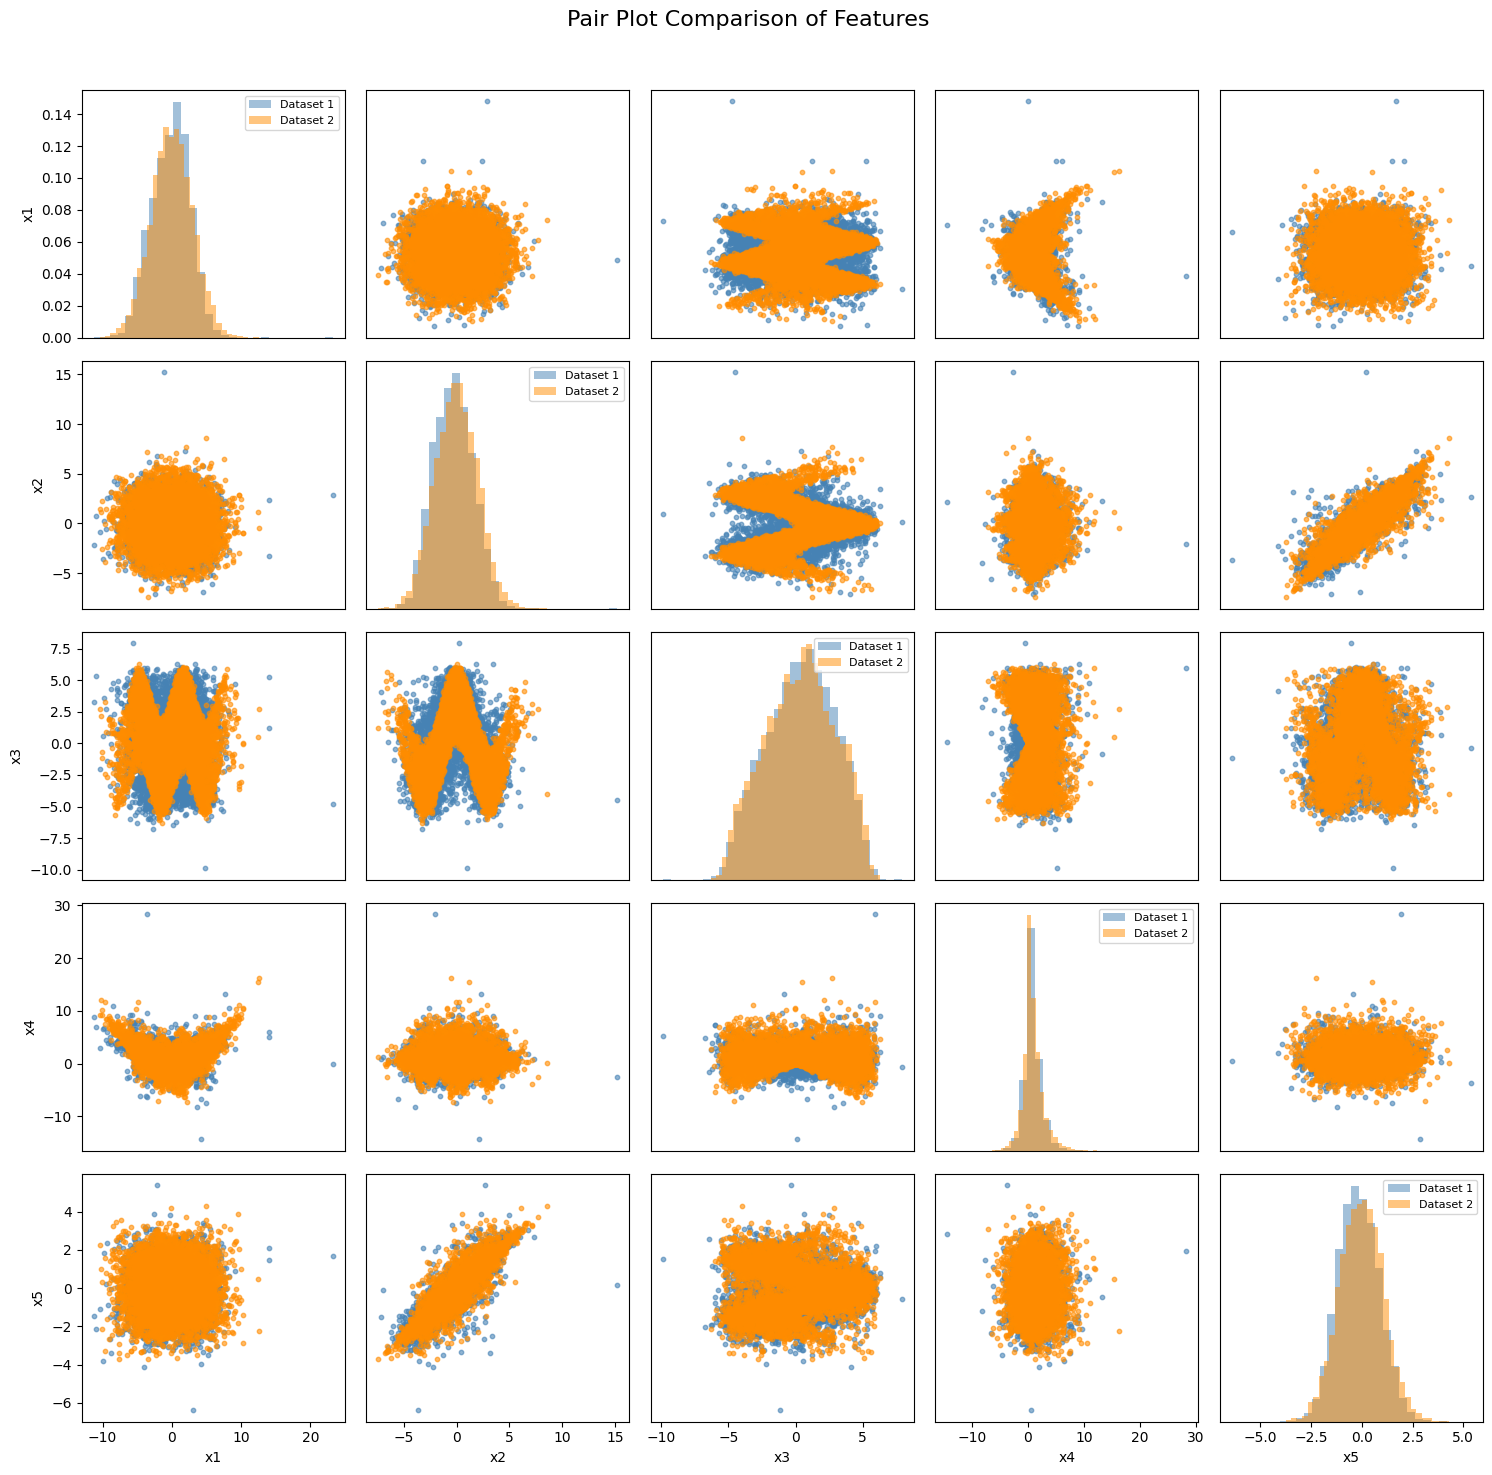

/srv/home/localusers/alexanderm20/P2/simformer-main/example/alex/Visualize.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96], pad=0.5)


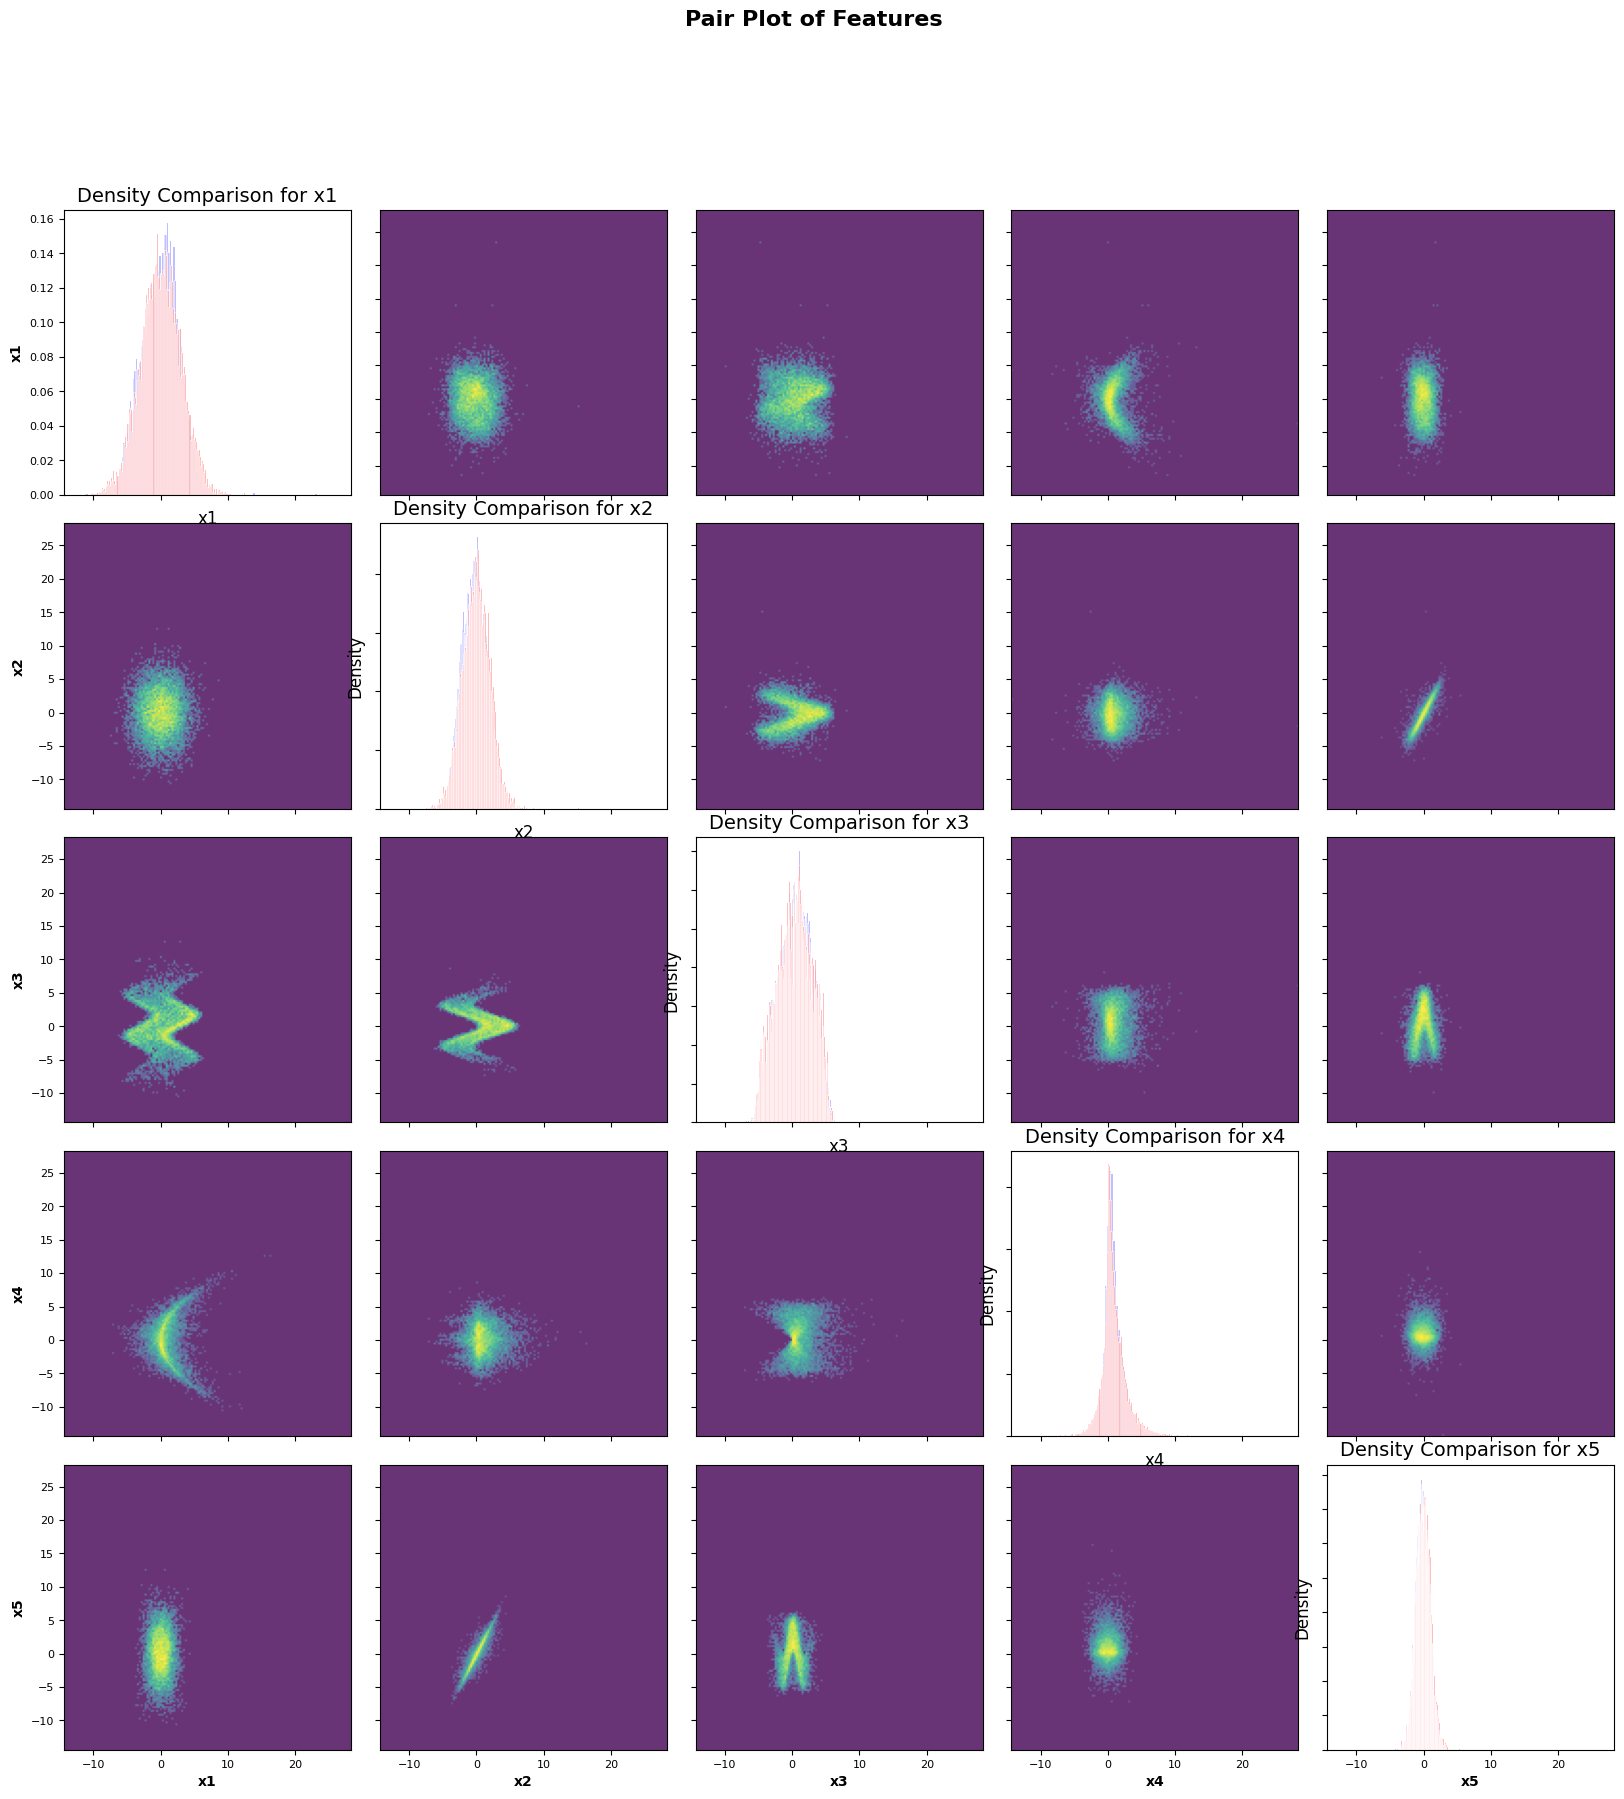

In [7]:

# Loop to iterate over each configuration and set values
for config_set in values_to_set:
    # Set values for SDEConfig
    set_config_values(sde_config, config_set["SDEConfig"])
    
    # Set values for SimformerConfig
    set_config_values(simformer_config, config_set["SimformerConfig"])
    
    # Set values for TransformerConfig
    set_config_values(transformer_config, config_set["TransformerConfig"])
    
    # Set values for TrainingConfig
    set_config_values(training_config, config_set["TrainingConfig"])
    
    # Set values for DiffusionConfig
    set_config_values(diffusion_config, config_set["DiffusionConfig"])
    # Access the parameters for this specific configuration and use them
    T = sde_config.T
    T_min = sde_config.T_min
    sigma_min = sde_config.sigma_min
    sigma_max = sde_config.sigma_max
    
    dim_value = simformer_config.dim_value
    dim_id = simformer_config.dim_id
    dim_condition = simformer_config.dim_condition
    
    num_heads = transformer_config.num_heads
    num_layers = transformer_config.num_layers
    attn_size = transformer_config.attn_size
    widening_factor = transformer_config.widening_factor
    
    epochs = training_config.epochs
    time_steps = diffusion_config.time_steps

    # Print or run the experiment for the current configuration
    print(f"SDEConfig: {sde_config}")
    print(f"SimformerConfig: {simformer_config}")
    print(f"TransformerConfig: {transformer_config}")
    print(f"TrainingConfig: {training_config}")
    print(f"DiffusionConfig: {diffusion_config}")
    print("---" * 20)

    # This creates the SDE for noise in diffusion model
        
    p0 = Independent(Empirical(data_clean), 1)
    sde = VESDE(p0, sigma_min=sigma_min, sigma_max=sigma_max)
    def output_scale_fn(t, x):
        scale = jnp.clip(sde.marginal_stddev(t, jnp.ones_like(x)), 1e-2, None)
        return (1/scale * x).reshape(x.shape)
    print("sample mean and std")
    print(jnp.squeeze(sde.marginal_mean(jnp.ones(1))))
    print(jnp.squeeze(sde.marginal_stddev(jnp.ones(1))))

    # This creates the model with the correct edge mask for handling nan values
    
    def marginalize(x: Array):
        # x is a single datapoint (vmap for batch)
        nan_indices = jnp.isnan(x)
        edge_mask = ~(nan_indices[:, None] | nan_indices[None, :])
        return edge_mask
    def model(t: Array, x: Array, node_ids: Array, condition_mask: Array, edge_mask: Optional[Array]=None):
        """Simplified Simformer model.
    
        Args:
            t (Array): Diffusion time
            x (Array): Value of the nodes
            node_ids (Array): Id of the nodes
            condition_mask (Array): Condition state of the nodes
            edge_mask (Array, optional): Edge mask for attention. If None, will be created using marginalize function
                based on NaN values in x. Defaults to None.
    
        Returns:
            Array: Score estimate of p(x_t)
        """
        # Get the batch size and sequence length from the shape of 'x'
        batch_size, seq_len, _ = x.shape
        
        # Prepare the condition_mask to ensure it is boolean and reshape it
        condition_mask = condition_mask.astype(jnp.bool_).reshape(-1, seq_len, 1)
        
        # If edge_mask is None, create it using the marginalize function
        if edge_mask is None:
            # Remove the last dimension and apply marginalize per sample in batch
            x_2d = x.reshape(batch_size, seq_len)
            # Vmap marginalize over the batch dimension
            edge_mask = jax.vmap(marginalize)(x_2d)
        
        # Ensure edge_mask has correct type
        edge_mask = edge_mask.astype(jnp.bool_)
        
        # Reshape node_ids for proper tokenization and embedding
        node_ids = node_ids.reshape(-1, seq_len)
        
        # Reshape diffusion time 't' to broadcast across the nodes
        t = t.reshape(-1, 1, 1)
        
        # Diffusion time embedding net (here we use a Gaussian Fourier embedding)
        embedding_time = GaussianFourierEmbedding(128)
        time_embeddings = embedding_time(t)
        
        # Tokenization part --------------------------------------------------------------------------------
        embedding_net_value = lambda x: jnp.repeat(x, dim_value, axis=-1)
        embedding_net_id = hk.Embed(nodes_max, dim_id, w_init=hk.initializers.RandomNormal(stddev=3.))
        condition_embedding = hk.get_parameter("condition_embedding", shape=(1,1,dim_condition), init=hk.initializers.RandomNormal(stddev=0.5))
        condition_embedding = condition_embedding * condition_mask
        condition_embedding = jnp.broadcast_to(condition_embedding, (batch_size, seq_len, dim_condition))
        
        # Embed inputs and broadcast
        value_embeddings = embedding_net_value(x)
        id_embeddings = embedding_net_id(node_ids)
        value_embeddings, id_embeddings = jnp.broadcast_arrays(value_embeddings, id_embeddings)
        
        # Concatenate embeddings
        x_encoded = jnp.concatenate([value_embeddings, id_embeddings, condition_embedding], axis=-1)
        # Example usage:
        #jax.debug.print("x_enoded is {}",x_encoded)
        # Transformer part --------------------------------------------------------------------------------
        model = Transformer(num_heads=num_heads, num_layers=num_layers, attn_size=attn_size, widening_factor=widening_factor)
        
        # Pass the edge_mask to the transformer for masked attention
        h = model(x_encoded, context=time_embeddings, mask=edge_mask)
        
        # Decode
        out = hk.Linear(1)(h)
        out = output_scale_fn(t, out)
        return out
    # In Haiku, we need to initialize the model first, before we can use it.
    init, model_fn = hk.without_apply_rng(hk.transform(model)) # Init function initializes the parameters of the model, model_fn is the actual model function (which takes the parameters as first argument, hence is a "pure function")
    # put data into the model i guess
    params = init(key, jnp.ones(data.shape[0]), data, node_ids, jnp.zeros_like(node_ids))
    # Here we can see the total number of parameters and their shapes
    print("Total number of parameters: ", jax.tree_util.tree_reduce(lambda x,y: x+y, jax.tree_map(lambda x: x.size, params)))
    jax.tree_util.tree_map(lambda x: x.shape, params) # Here we can see the shapes of the parameters

    # modified matching loss function in order to work with nan values
    
    def denoising_score_matching_loss(
        params: PyTree,
        key: PRNGKey,
        times: Array,
        xs_target: Array,
        xs_target_clean: Array,
        loss_mask: Optional[Array],
        *args,
        model_fn: Callable,
        mean_fn: Callable,
        std_fn: Callable,
        weight_fn: Callable,
        axis: int = -2,
        rebalance_loss: bool = False,
        **kwargs,
    ) -> Array:
        """This function computes the denoising score matching loss. Which can be used to train diffusion models.
    
        Args:
            params (PyTree): Parameters of the model_fn given as a PyTree.
            key (PRNGKey): Random generator key.
            times (Array): Time points, should be broadcastable to shape (batch_size, 1).
            xs_target (Array): Target distribution.
            loss_mask (Optional[Array]): Mask for the target distribution. If None, no mask is applied, should be broadcastable to shape (batch_size, 1).
            model_fn (Callable): Score model that takes parameters, times, and samples as input and returns the score. Should be a function of the form model_fn(params, times, xs_t, *args) -> s_t.
            mean_fn (Callable): Mean function of the SDE.
            std_fn (Callable): Std function of the SDE.
            weight_fn (Callable): Weight function for the loss.
            axis (int, optional): Axis to sum over. Defaults to -2.
            rebalance_loss (bool, optional): Whether to rebalance the loss by the number of valid elements. Defaults to False.
    
        Returns:
            Array: Loss
        """
        eps = jax.random.normal(key, shape=xs_target.shape)
        mean_t = mean_fn(times, xs_target_clean)
        std_t = std_fn(times, xs_target_clean)
        xs_t = mean_t + std_t * eps


        #jax.debug.print("mean_t is {}",mean_t.shape)
        #jax.debug.print("std_t is {}",std_t.shape)
    
        score_pred = model_fn(params, times, xs_t, *args, **kwargs)
        score_target = -eps / std_t
        #jax.debug.print("score_pred is {}",score_pred)
        #jax.debug.print("score_target is {}",score_target)
    
        # Compute the squared error
        loss = (score_pred - score_target) ** 2
        
        # Apply the combined mask to the loss
        loss = jnp.where(loss_mask, 0.0, loss)
        
        # Apply weighting and sum over specified axis
        loss = weight_fn(times) * jnp.sum(loss, axis=axis, keepdims=True)
        
        # Optional rebalancing
        if rebalance_loss:
            num_elements = jnp.sum(~loss_mask, axis=axis, keepdims=True)
            loss = jnp.where(num_elements > 0, loss / num_elements, 0.0)
        
        # Mean over batch
        loss = jnp.mean(loss)
        
    
        return loss
    
    
    def safe_weight_fn(t):
        """
        Example of a numerically stable weight function.
        Replace this with your actual weight function.
        """
        # Ensure time values are finite
        t = jnp.nan_to_num(t, 0.0)
        # Compute weights with clipping to prevent extreme values
        weights = jnp.clip(1.0 / (1.0 + t), 1e-6, 1e6)
        return weights
    
    
    def marginalize(x: Array):
        # x is a single datapoint (vmap for batch)
        nan_indices = jnp.isnan(x)
        edge_mask = ~(nan_indices[:, None] | nan_indices[None, :])
        return edge_mask
    
    def weight_fn(t: Array):
        # Calculate weighting based on the diffusion process at time 't'.
        # sde.diffusion(t, jnp.ones((1,1,1))) computes diffusion for all-ones input.
        # Squared and clipped to ensure it's bounded by 1e-4.
        return jnp.clip(sde.diffusion(t, jnp.ones((1,1,1)))**2, 1e-4)
    
    def marginalize_node(rng: PRNGKey, edge_mask: Array):
        # Remove a random node from the graph's adjacency matrix
        idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
        edge_mask = edge_mask.at[idx, :].set(False)  # Remove outgoing edges
        edge_mask = edge_mask.at[:, idx].set(False)  # Remove incoming edges
        edge_mask = edge_mask.at[idx, idx].set(True) # Keep the self-loop
        return edge_mask
    
    
    def loss_fn(params: dict, key: PRNGKey, batch_size: int = 1024):
        # Split the random key for different random operations
        rng_time, rng_sample, rng_data, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 6)
        
        # Generate random times between T_min and 1.0 for each sample in the batch
        times = jax.random.uniform(rng_time, (batch_size, 1, 1), minval=T_min, maxval=1.0)
        
        # batch_xs format is (1024, 3, 1)
        # Generate a batch of data using the generate_data function
        batch_xs,batch_xs_clean = generate_data_combined_normal_par(key, batch_size,means,stds)
        # Node IDs to identify the nodes in the graph (assumes `node_ids` is predefined)
        ids = node_ids
        
        # Create a binary condition mask indicating which nodes should be conditioned on
        condition_mask = jax.random.bernoulli(rng_condition, 0.333, shape=(batch_xs.shape[0], batch_xs.shape[1]))
        
        # Prevent conditioning on all nodes
        condition_mask_all_one = jnp.all(condition_mask, axis=-1, keepdims=True)
        condition_mask *= ~condition_mask_all_one
        
        # Expand dimensions of the condition mask for further computations
        condition_mask = condition_mask[..., None]
    
        # Create an initial dense edge mask (fully connected graph structure) for a subset of the batch
        edge_mask = jnp.ones((4 * batch_size // 5, batch_xs.shape[1], batch_xs.shape[1]), dtype=jnp.bool_)
        
        # Generate sparse masks by marginalizing over a subset of the batch
        marginal_mask = jax.vmap(marginalize_node, in_axes=(0, None))(jax.random.split(rng_edge_mask1, batch_size // 5), edge_mask[0])
        
        # Concatenate the dense and sparse edge masks
        edge_masks = jnp.concatenate([edge_mask, marginal_mask], axis=0)
        
        # Randomly select between dense and sparse edge masks for each sample
        edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0)
            # Apply marginalization based on NaN values in batch_xs to update the edge mask
        margarita = jax.vmap(marginalize)(batch_xs).squeeze(-1)  # Produces a mask with True where edges should be active
        edge_masks = edge_masks * margarita  # Apply the margarita mask to the edge mask)
        #jax.debug.print("edge mask is {}",edge_masks)
    
    
        # Compute the loss using the denoising score matching function
        loss = denoising_score_matching_loss(
            params, rng_sample, times, batch_xs,batch_xs_clean, condition_mask, 
            model_fn=model_fn, 
            mean_fn=sde.marginal_mean, 
            std_fn=sde.marginal_stddev, 
            weight_fn=weight_fn, 
            node_ids=ids, 
            condition_mask=condition_mask, 
            edge_mask=edge_masks
        )
        
        return loss
    import jax
    import jax.numpy as jnp
    import jax.random as jrandom
    from functools import partial
    import optax

    # This part is training the transformer model until a good result is reached which does not improve for some iterations
    
    # Assuming optax optimizer, params, and loss_fn are already defined
    optimizer = optax.adam(1e-3)
    opt_state = optimizer.init(params)
    
    @partial(jax.pmap, axis_name="num_devices")
    def update(params, rng, opt_state):
        loss, grads = jax.value_and_grad(loss_fn)(params, rng)
        
        # Average loss and gradients across devices
        loss = jax.lax.pmean(loss, axis_name="num_devices")
        grads = jax.lax.pmean(grads, axis_name="num_devices")
        #jax.debug.print("loss is {}",loss)
        #jax.debug.print("grads is {}",grads)
        # Apply optimizer updates
        updates, opt_state = optimizer.update(grads, opt_state, params=params)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state
    
    n_devices = jax.local_device_count()
    replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
    replicated_opt_state = jax.tree_map(lambda x: jnp.array([x] * n_devices), opt_state)
    

    best_loss = float('inf')
    no_improvement_counter = 0
    best_params = None

    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(100):
            key, subkey = jrandom.split(key)
            loss, replicated_params, replicated_opt_state = update(
                replicated_params,
                jax.random.split(subkey, n_devices),
                replicated_opt_state
            )
            # Average loss for this step and accumulate for epoch
            epoch_loss += loss[0] / 100

        # Print the epoch loss
        print(f"Epoch {epoch + 1} loss: {epoch_loss}")

        # Check for improvement
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            no_improvement_counter = 0
            best_params = jax.tree_map(lambda x: x.copy(), replicated_params)
        else:
            no_improvement_counter += 1

        # Stop if no improvement over 5 iterations
        if no_improvement_counter >= 5:
            print("Stopping early due to no improvement.")
            break

    # Retrieve final trained parameters (take best parameters)
    params = jax.tree_map(lambda x: x[0], best_params)
    
    
    # This part is for the diffusion model 
    
    from functools import partial
    from probjax.utils.sdeint import sdeint
    
    condition_mask = jnp.zeros((nodes_max,))
    condition_value = jnp.zeros((nodes_max,))
    
    # Reverse SDE drift
    def drift_backward(t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=None, score_fn = model_fn, replace_conditioned=True):
        score = score_fn(params, t.reshape(-1, 1, 1), x.reshape(-1, len(node_ids), 1), node_ids,condition_mask[:len(node_ids)], edge_mask=edge_mask)
        score = score.reshape(x.shape)
        #jax.debug.print("score dif is {}",score )
        f =  sde.drift(t,x) - sde.diffusion(t,x)**2 * score
        if replace_conditioned:
            f = f * (1-condition_mask[:len(node_ids)])
        
        return f
    
    # Reverse SDE diffusion
    def diffusion_backward(t,x, node_ids=node_ids,condition_mask=condition_mask, replace_conditioned=True):
        b =  sde.diffusion(t,x) 
        #jax.debug.print("diffusion is {}",b )
        if replace_conditioned:
            b = b * (1-condition_mask[:len(node_ids)])
        return b

    end_std = jnp.squeeze(sde.marginal_stddev(jnp.ones(1)))
    end_mean = jnp.squeeze(sde.marginal_mean(jnp.ones(1)))
    print(end_std.shape)
    print(end_std)
    print(end_mean)
    
    @partial(jax.jit, static_argnums=(1, 3, 7, 8))
    def sample_fn(key, shape, node_ids=node_ids, time_steps=time_steps, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)), edge_mask=None, score_fn=model_fn, replace_conditioned=True):
        condition_mask = condition_mask[:len(node_ids)]
        key1, key2 = jrandom.split(key, 2)
        x_T = jax.random.normal(key1, shape + (len(node_ids),)) * end_std[node_ids] + end_mean[node_ids]
        
        if replace_conditioned:
            x_T = x_T * (1-condition_mask) + condition_value * condition_mask
        
        keys = jrandom.split(key2, shape)
        ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal"), in_axes=(0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn, replace_conditioned=replace_conditioned), lambda t, x: diffusion_backward(t, x, node_ids, condition_mask, replace_conditioned=replace_conditioned), x_T, jnp.linspace(1., T_min, time_steps))
        return ys
    # Full joint estimation
    # Taking samples and visualizing them (after some formation)
    samples = sample_fn(jrandom.PRNGKey(0), (10000,), node_ids, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)))
    samples = denormalize_data(samples, means, stds)
    samples_new = samples[:,-1,:]
    samples_ref = samples[:,-1,:]
    data_new = data_clean_no_norm[:, :, -1]
    data_seb = data_no_norm[:, :, -1]
    compute_all_metrics(samples_new,data_new)
    plot_pairplot_comparison_points(samples_new,data_new,labels)
    plot_pairplot_comp_kde2(samples_new,data_new,labels)

 

# 5) Testing Sampling

In [ ]:
Here it is shown how good the simformer works by testing the sampling.

For that a point is generated from the data generation function. 
Then SBI/Simformer perform Sampling and sample 1000 points for theta1 based on all the other parameters (theta2,x1,x2,x3)

The amount of points which are smaller than the real point are now called left values and counted. For enough iterations it should approximate to about 50 percent

It is also measured how the KDE value on the real point is so how close the simformer/SBI is to measuring the real point by putting a function above the sampled points and measuring at the position of the real point

Then also a QQ-Plot and CDF plot are generated from the left values. In this diagrams the ideal line is also displayed. 

HINT: KDE value should be as small as possible as I use the negative log liklhood. 

## Testing the Simformer

Iteration 1/100 - Metric (Log KDE): -2.525971061624144
Iteration 2/100 - Metric (Log KDE): -2.439956958463272
Iteration 3/100 - Metric (Log KDE): -1.9357010629941893
Iteration 4/100 - Metric (Log KDE): -1.5647485676821802
Iteration 5/100 - Metric (Log KDE): -1.7213246500043375
Iteration 6/100 - Metric (Log KDE): -2.619345928244946
Iteration 7/100 - Metric (Log KDE): -1.321928305616801
Iteration 8/100 - Metric (Log KDE): -1.5697478039851092
Iteration 9/100 - Metric (Log KDE): -1.0727878665929644
Iteration 10/100 - Metric (Log KDE): -2.227728948930748
Iteration 10/100 completed.
Iteration 11/100 - Metric (Log KDE): -2.951410638090524
Iteration 12/100 - Metric (Log KDE): -2.129777053924558
Iteration 13/100 - Metric (Log KDE): -1.4735080332768415
Iteration 14/100 - Metric (Log KDE): -1.8065476179566264
Iteration 15/100 - Metric (Log KDE): -2.1067883682418884
Iteration 16/100 - Metric (Log KDE): -1.7828856451142467
Iteration 17/100 - Metric (Log KDE): -2.0679497549902734
Iteration 18/100 - 

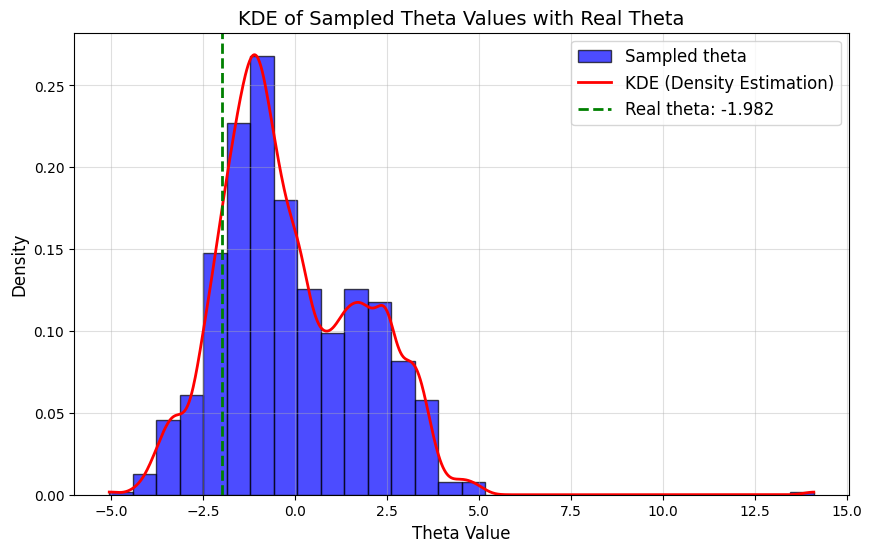

Iteration 100/100 - Metric (Log KDE): -1.7469420165064342
Iteration 100/100 completed.


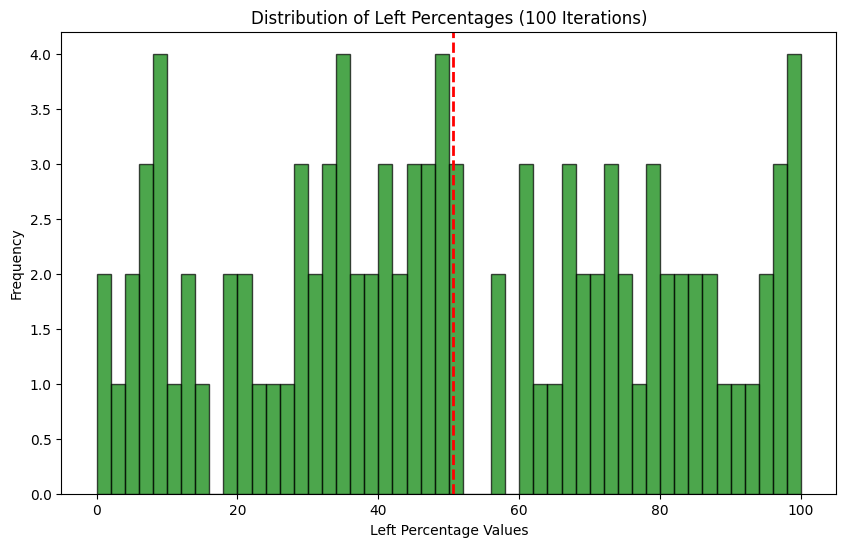

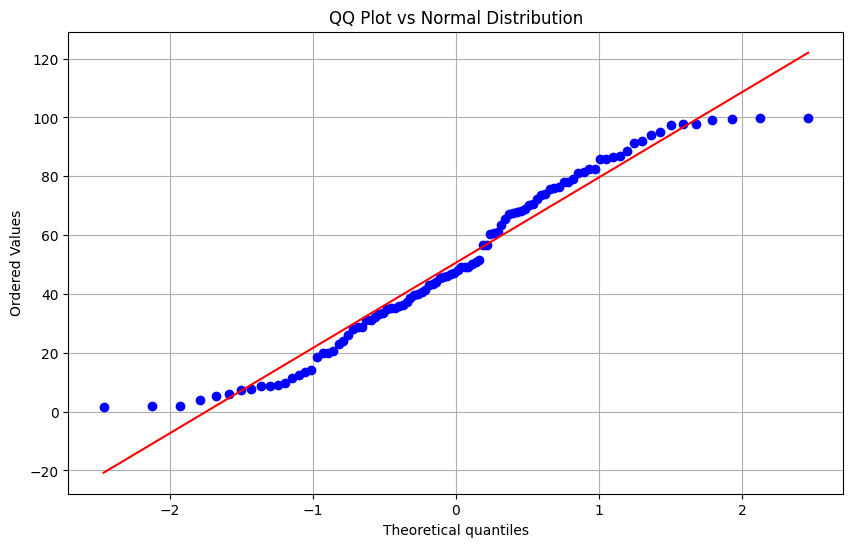

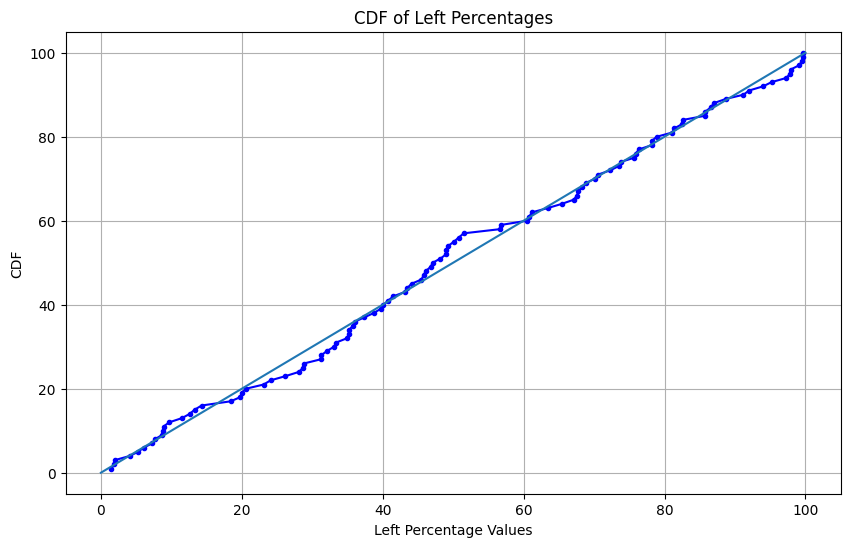

Average Absolute Difference CDF: 1.45
Average Left Percentage: 50.66%
95% Confidence Interval: [45.04%, 56.43%]
Average left percentage: 50.66%
Metric Name                   Value
mean_left_percentage          50.608001708984375
std_left_percentage           28.910051345825195
median_left_percentage        47.650001525878906
ks_statistic                  0.96998
ks_pvalue                     0.00000
mean_kde                      -2.05471
total kde                     -205.47094


In [8]:

# Assuming necessary imports and setup
avg_left, left_percentages, metrics = evaluate_conditional_sampling(
    generate_data_fn=generate_data_combined_normal_par,
    sample_fn=sample_fn,
    denormalize_data=denormalize_data,
    means=means,
    stds=stds,
    node_ids=node_ids,
    iterations=100,
    plot_results=True,
    extended_plot=True,
    samples_new=samples_new,
    data_new=data_new
)
def print_metrics(metrics: dict):
    """
    Prints each metric in the metrics dictionary in a nicely formatted manner.
    
    Args:
        metrics (dict): Dictionary containing metric names as keys and their values as values.
    """
    print("Metric Name".ljust(30) + "Value")
    print("=" * 45)
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name.ljust(30)}{metric_value:.5f}" if isinstance(metric_value, (float, int)) else f"{metric_name.ljust(30)}{metric_value}")
        
print(f"Average left percentage: {avg_left:.2f}%")
print_metrics(metrics)

## Testing SBI

Hint: Yout mabeye need to scroll down in the code field to see the final results as sbi displays every step and I can not turn that off

/srv/environments/alexanderm20/venvs/job_9503/lib/python3.12/site-packages/sbi/utils/sbiutils.py:38: UserWarning: Beware that there is only a single unique element in the simulated data.
            If this is intended, make sure to set `z_score_x='none'` as z-scoring would
            result in NaNs
  warnings.warn(


 Neural network successfully converged after 239 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

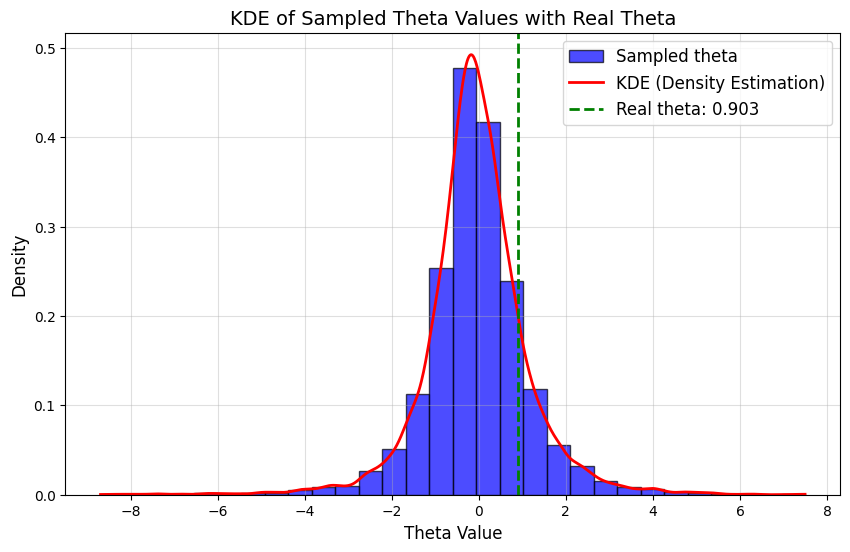

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

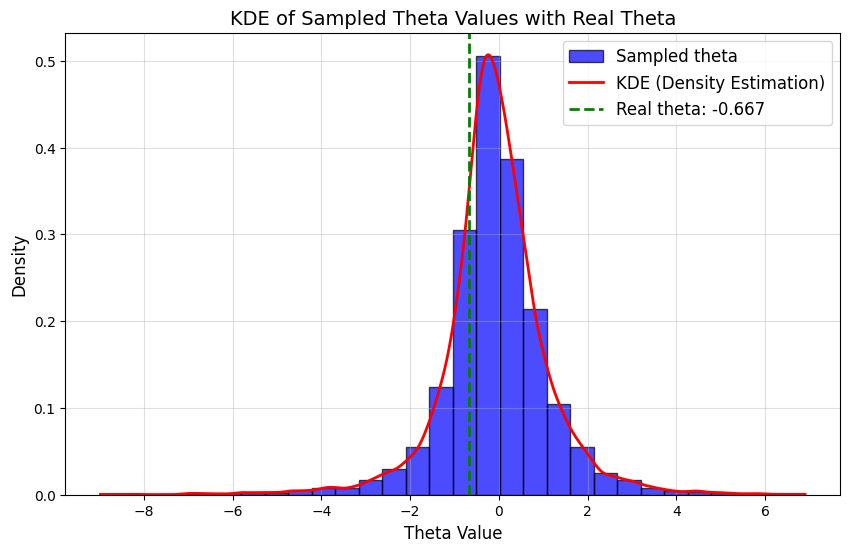

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

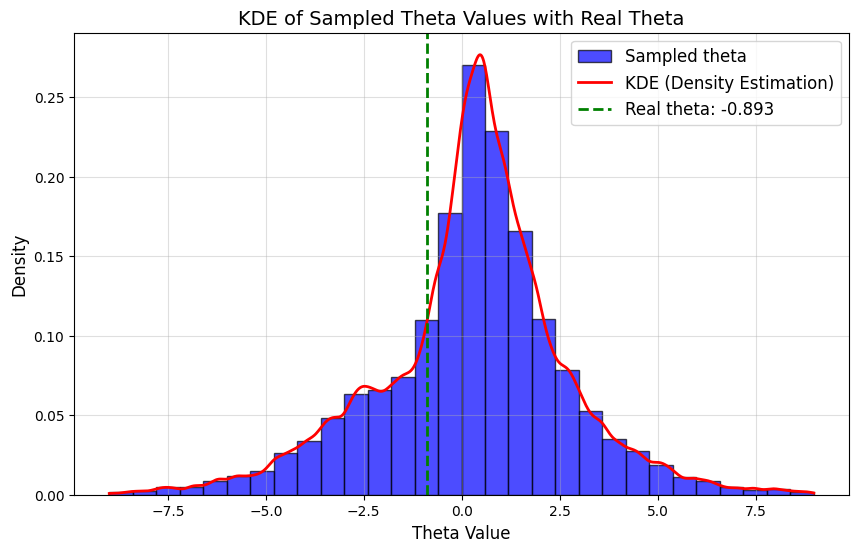

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

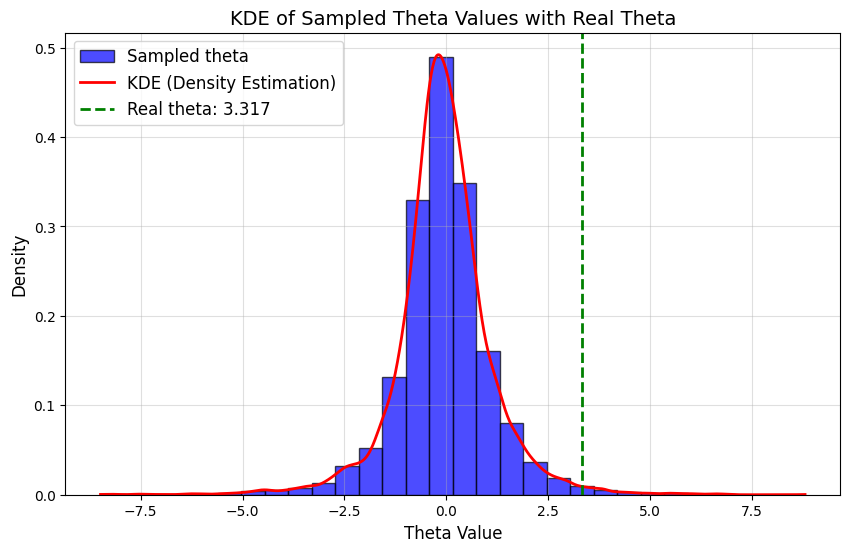

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

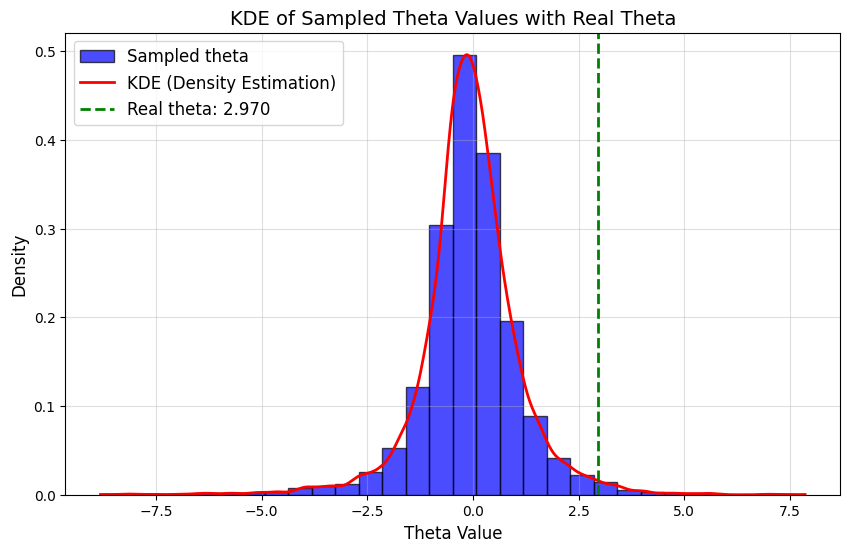

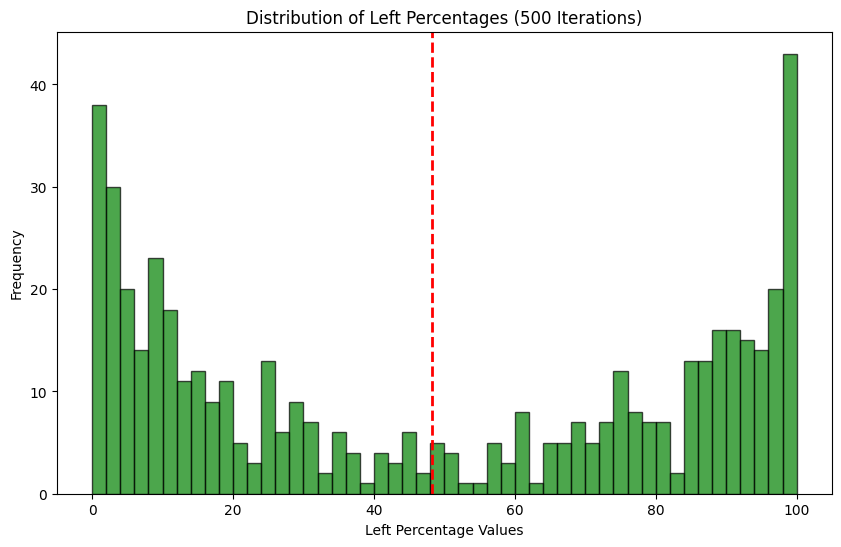

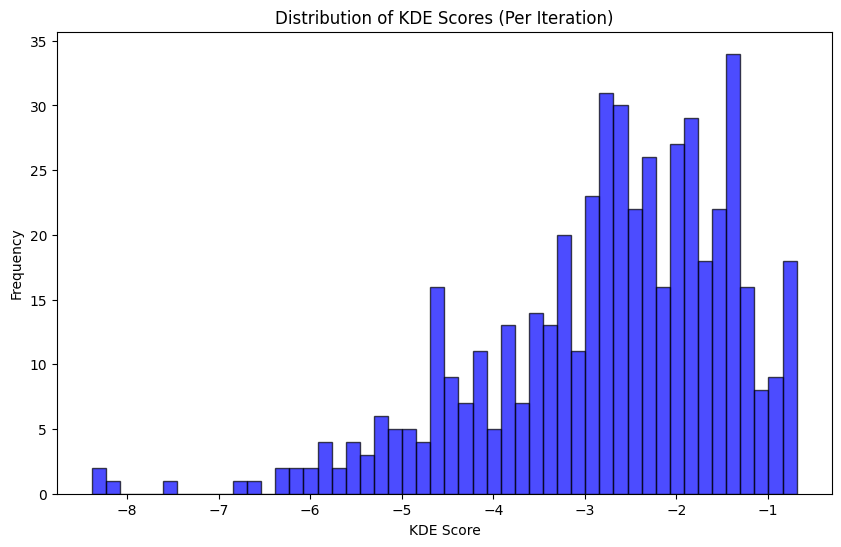

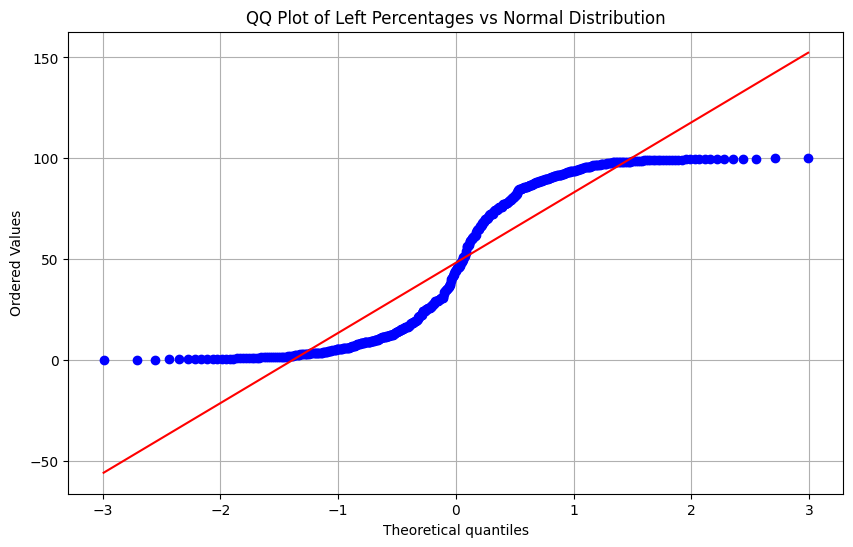

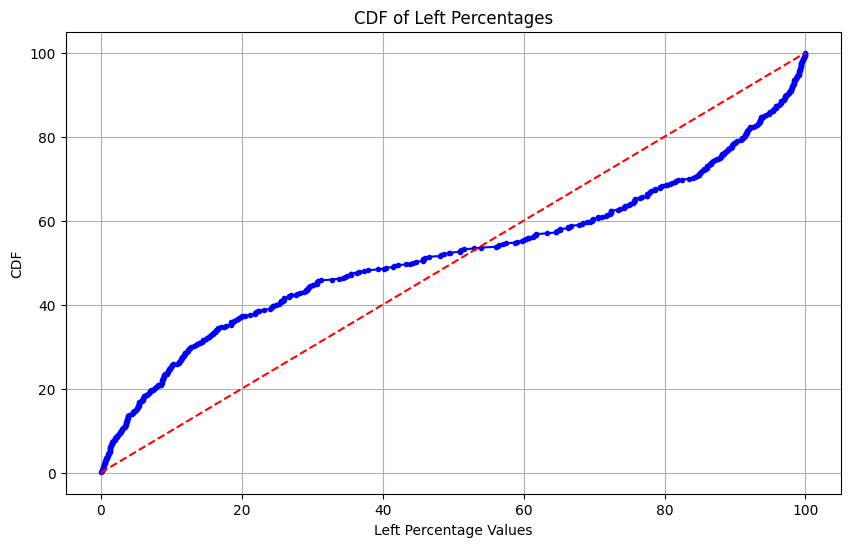


Evaluation Metrics:
Average Left Percentage: 48.23%
Standard Deviation: 37.32
Median Left Percentage: 44.47%
Mean KDE Metric (log-likelihood): -2.76
Sum KDE Metric (log-likelihood): -1378.85


In [18]:
def plot_kde_with_samples(theta_samples, real_theta, bandwidth='scott'):
    """
    Plots a histogram of sampled thetas and overlays the KDE plot.
    
    Args:
        theta_samples: Array of sampled theta values
        real_theta: The true value of theta to overlay
        bandwidth: Bandwidth parameter for KDE, default is 'scott'
    """
    # Fit KDE to the theta samples
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(theta_samples[:, np.newaxis])
    
    # Generate values for the x-axis (range around the real theta for better visualization)
    x_values = np.linspace(np.min(theta_samples), np.max(theta_samples), 1000)[:, np.newaxis]
    
    # Evaluate the KDE on the range of values
    kde_values = np.exp(kde.score_samples(x_values))
    
    # Plot the histogram of the theta samples
    plt.figure(figsize=(10, 6))
    plt.hist(theta_samples, bins=30, density=True, alpha=0.7, color='blue', edgecolor='black', label='Sampled theta')
    
    # Overlay the KDE plot
    plt.plot(x_values, kde_values, color='red', linewidth=2, label='KDE (Density Estimation)')
    
    # Mark the true theta with a vertical line
    plt.axvline(real_theta, color='green', linestyle='--', linewidth=2, label=f'Real theta: {real_theta:.3f}')
    
    # Add labels and legend
    plt.title('KDE of Sampled Theta Values with Real Theta', fontsize=14)
    plt.xlabel('Theta Value', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.4)
    plt.show()


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_pairplot_comp_kde2_with_lines(samples1, samples2, feature_labels, real_point, title="Pair Plot of Features", bins=150):
    """
    Plots pairwise relationships with consistent scaling and styling.
    """
    df1 = pd.DataFrame(samples1, columns=feature_labels)
    df2 = pd.DataFrame(samples2, columns=feature_labels)
    real_point = np.array(real_point).ravel()
    n_features = len(feature_labels)
    
    # Calculate global min/max for each feature
    feature_ranges = {}
    for feature in feature_labels:
        min_val = min(df1[feature].min(), df2[feature].min())
        max_val = max(df1[feature].max(), df2[feature].max())
        feature_ranges[feature] = (min_val, max_val)
    
    # Create figure with consistent spacing
    fig, axes = plt.subplots(n_features, n_features, 
                            figsize=(4 * n_features, 4 * n_features),
                            gridspec_kw={'wspace': 0.2, 'hspace': 0.2})
    fig.suptitle(title, fontsize=16, fontweight='bold', y=0.95)
    
    # Use consistent colormap
    cmap = plt.cm.viridis
    
    for i, feature1 in enumerate(feature_labels):
        for j, feature2 in enumerate(feature_labels):
            ax = axes[i, j]
            
            # Set consistent axis limits
            ax.set_xlim(feature_ranges[feature2])
            ax.set_ylim(feature_ranges[feature1])
            
            if i == j:
                # Diagonal: Histograms
                bins_range = np.linspace(*feature_ranges[feature1], bins)
                ax.hist(df1[feature1], bins=bins_range, density=True, 
                       alpha=0.5, color='blue', label='Dataset 1')
                ax.hist(df2[feature1], bins=bins_range, density=True, 
                       alpha=0.5, color='red', label='Dataset 2')
                ax.axvline(real_point[i], color='black', linestyle='--', 
                          linewidth=1.5, label='Real Point')
                
                max_density = max(
                    np.histogram(df1[feature1], bins=bins_range, density=True)[0].max(),
                    np.histogram(df2[feature1], bins=bins_range, density=True)[0].max()
                )
                ax.set_ylim(0, max_density * 1.1)
                
            elif i < j:
                # Upper triangle: Dataset 1
                x1, y1 = df1[feature2], df1[feature1]
                h1 = np.histogram2d(x1, y1, bins=bins, 
                                  range=[feature_ranges[feature2], feature_ranges[feature1]])[0]
                ax.imshow(np.log1p(h1.T), extent=[*feature_ranges[feature2], *feature_ranges[feature1]], 
                         origin='lower', aspect='auto', cmap=cmap)
                ax.axhline(real_point[i], color='red', linestyle='--', linewidth=1.5)
                ax.axvline(real_point[j], color='red', linestyle='--', linewidth=1.5)
                
            elif i > j:
                # Lower triangle: Dataset 2
                x2, y2 = df2[feature2], df2[feature1]
                h2 = np.histogram2d(x2, y2, bins=bins,
                                  range=[feature_ranges[feature2], feature_ranges[feature1]])[0]
                ax.imshow(np.log1p(h2.T), extent=[*feature_ranges[feature2], *feature_ranges[feature1]], 
                         origin='lower', aspect='auto', cmap=cmap)
                ax.axhline(real_point[i], color='red', linestyle='--', linewidth=1.5)
                ax.axvline(real_point[j], color='red', linestyle='--', linewidth=1.5)
            
            # Consistent font sizes and tick parameters
            ax.tick_params(axis='both', which='major', labelsize=10)
            
            if i == n_features - 1:
                ax.set_xlabel(feature2, fontsize=12)
            if j == 0:
                ax.set_ylabel(feature1, fontsize=12)
            
            if i < n_features - 1:
                ax.set_xticklabels([])
            if j > 0:
                ax.set_yticklabels([])

    # Adjust layout and legend
    plt.tight_layout()
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5), 
              fontsize=12, borderaxespad=0.)
    
    plt.show()
    plt.close()

import numpy as np
import torch
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from scipy import stats
from sbi.inference import SNPE
from sbi.utils import BoxUniform
# Adjusted loop for KDE evaluation

num_iterations = 500
left_percentages = []
kde_scores = []
# Step 1: Define the prior
num_features = 5  # Assuming 5 features: theta1, theta2, x1, x2, x3
low_values = torch.full((num_features,), -9.0)
high_values = torch.full((num_features,), 9.0)
prior = BoxUniform(low=low_values, high=high_values)

# Step 2: Generate all required data points before entering the loop
num_samples = 5000  # Number of data points to generate before the loop
_, all_new_points = generate_data_combined_normal_par(key, num_iterations, means, stds)
training_data, _ = generate_data_combined_normal_par(key, num_samples, means, stds)
all_new_points_np = np.array(training_data)

# Check and reshape data from (num_samples, features, 1) to (num_samples, features)
if all_new_points_np.ndim == 3 and all_new_points_np.shape[-1] == 1:
    all_new_points_np = all_new_points_np.squeeze(-1)  # Remove the last dimension

# Impute NaN values using KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)
all_new_points_np = knn_imputer.fit_transform(all_new_points_np)

# Optionally, reshape back to (num_samples, features, 1) if required by subsequent steps
all_new_points_np = all_new_points_np[:, :, np.newaxis]  # Add the last dimension back

# Step 3: Generate training data and train the SBI model
data_np = all_new_points_np.reshape(num_samples, -1)
parameters = torch.tensor(data_np, dtype=torch.float32)  # Combined theta1, theta2, x1, x2, x3
observations = torch.zeros(parameters.size(0), 1, dtype=torch.float32)  # Dummy observations

# Train the model
inference = SNPE(prior)
density_estimator = inference.append_simulations(parameters, observations).train()
posterior = inference.build_posterior(density_estimator)


# Function to calculate KDE score for the real point
def calculate_kde_for_real_point(samples: np.ndarray, real_point: float) -> float:
    """Calculate KDE for a real point using posterior samples."""
    kde = KernelDensity(kernel='gaussian', bandwidth="scott")
    kde.fit(samples.reshape(-1, 1))
    real_point_log_prob = kde.score_samples([[real_point]])  # Evaluate KDE at the real point
    return real_point_log_prob[0]  # Return the log of the probability densit
def denormalize_data_point(normalized_data: jnp.ndarray, means: jnp.ndarray, 
                     stds: jnp.ndarray) -> jnp.ndarray:
    """
    Reverse the normalization process to recover the original scale of the data.
    
    Args:
        normalized_data: Array of shape (n_samples, time_steps, n_features)
        means: Mean values used in normalization (shape: n_features)
        stds: Standard deviation values used in normalization (shape: n_features)
        
    Returns:
        denormalized_data: Array in original scale
    """
    means_broadcast = means.reshape(1, -1, 1)  # Shape: (1, 5, 1)
    stds_broadcast = stds.reshape(1, -1, 1)    # Shape: (1, 5, 1)
    
    denormalized = normalized_data * stds_broadcast + means_broadcast
    
    return denormalized



for i in range(num_iterations):
    new_point = all_new_points[i]
    new_point_theta = denormalize_data_point(new_point,means,stds)
    new_point_theta = new_point_theta[0].flatten()
    true_theta1 = float(new_point_theta[0])
    new_point_np = np.array(new_point)
    observation_scalar = torch.tensor([np.mean(new_point_np[1:])], dtype=torch.float32).unsqueeze(0)
    
    posterior.set_default_x(observation_scalar)
    posterior_samples = posterior.sample((10000,))
    posterior_samples_np = np.array(posterior_samples)
    theta1_samples = posterior_samples_np[:, 0]
    
    # Calculate percentage of samples left of the true theta1
    left_of_true_theta1 = theta1_samples < true_theta1
    percentage_left = (np.sum(left_of_true_theta1) / 10000) * 100
    left_percentages.append(percentage_left)
    
    # Calculate KDE score for the real point
    kde_score = calculate_kde_for_real_point(theta1_samples, true_theta1)
    kde_scores.append(kde_score)
    if (i + 1) % 100 == 0:
        plot_kde_with_samples(theta1_samples,true_theta1)

# Calculate metrics
metrics = {
    'mean_left_percentage': np.mean(left_percentages),
    'std_left_percentage': np.std(left_percentages),
    'median_left_percentage': np.median(left_percentages),
    'kde_metric': np.mean(kde_scores),
    'kde_metric_sum': np.sum(kde_scores),
}

# Plotting function
def plot_kde_evaluation(left_percentages, kde_scores, metrics):
    plt.figure(figsize=(10, 6))
    plt.hist(left_percentages, bins=50, range=[0, 100], alpha=0.7, color='green', edgecolor='black')
    plt.axvline(x=metrics['mean_left_percentage'], color='red', linestyle='--', linewidth=2)
    plt.title(f"Distribution of Left Percentages ({len(left_percentages)} Iterations)")
    plt.xlabel('Left Percentage Values')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.hist(kde_scores, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title("Distribution of KDE Scores (Per Iteration)")
    plt.xlabel('KDE Score')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 6))
    stats.probplot(left_percentages, dist="norm", plot=plt)
    plt.title("QQ Plot of Left Percentages vs Normal Distribution")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    sorted_vals = np.sort(left_percentages)
    cdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    plt.plot(sorted_vals, cdf * 100, marker='.', linestyle='-', color='blue')
    plt.plot([0, 100], [0, 100], linestyle='--', color='red')
    plt.title('CDF of Left Percentages')
    plt.xlabel('Left Percentage Values')
    plt.ylabel('CDF')
    plt.grid(True)
    plt.show()

# Plot results
plot_kde_evaluation(left_percentages, kde_scores, metrics)

# Print metrics
print("\nEvaluation Metrics:")
print(f"Average Left Percentage: {metrics['mean_left_percentage']:.2f}%")
print(f"Standard Deviation: {metrics['std_left_percentage']:.2f}")
print(f"Median Left Percentage: {metrics['median_left_percentage']:.2f}%")
print(f"Mean KDE Metric (log-likelihood): {metrics['kde_metric']:.2f}")
print(f"Sum KDE Metric (log-likelihood): {metrics['kde_metric_sum']:.2f}")


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Generated samples shape: (10000, 5)
Mean of samples: [-0.009  0.008  0.024  0.026  0.089]
Standard deviation of samples: [0.846 0.8   0.916 0.759 0.801]


/srv/home/localusers/alexanderm20/P2/simformer-main/example/alex/Visualize.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96], pad=0.5)


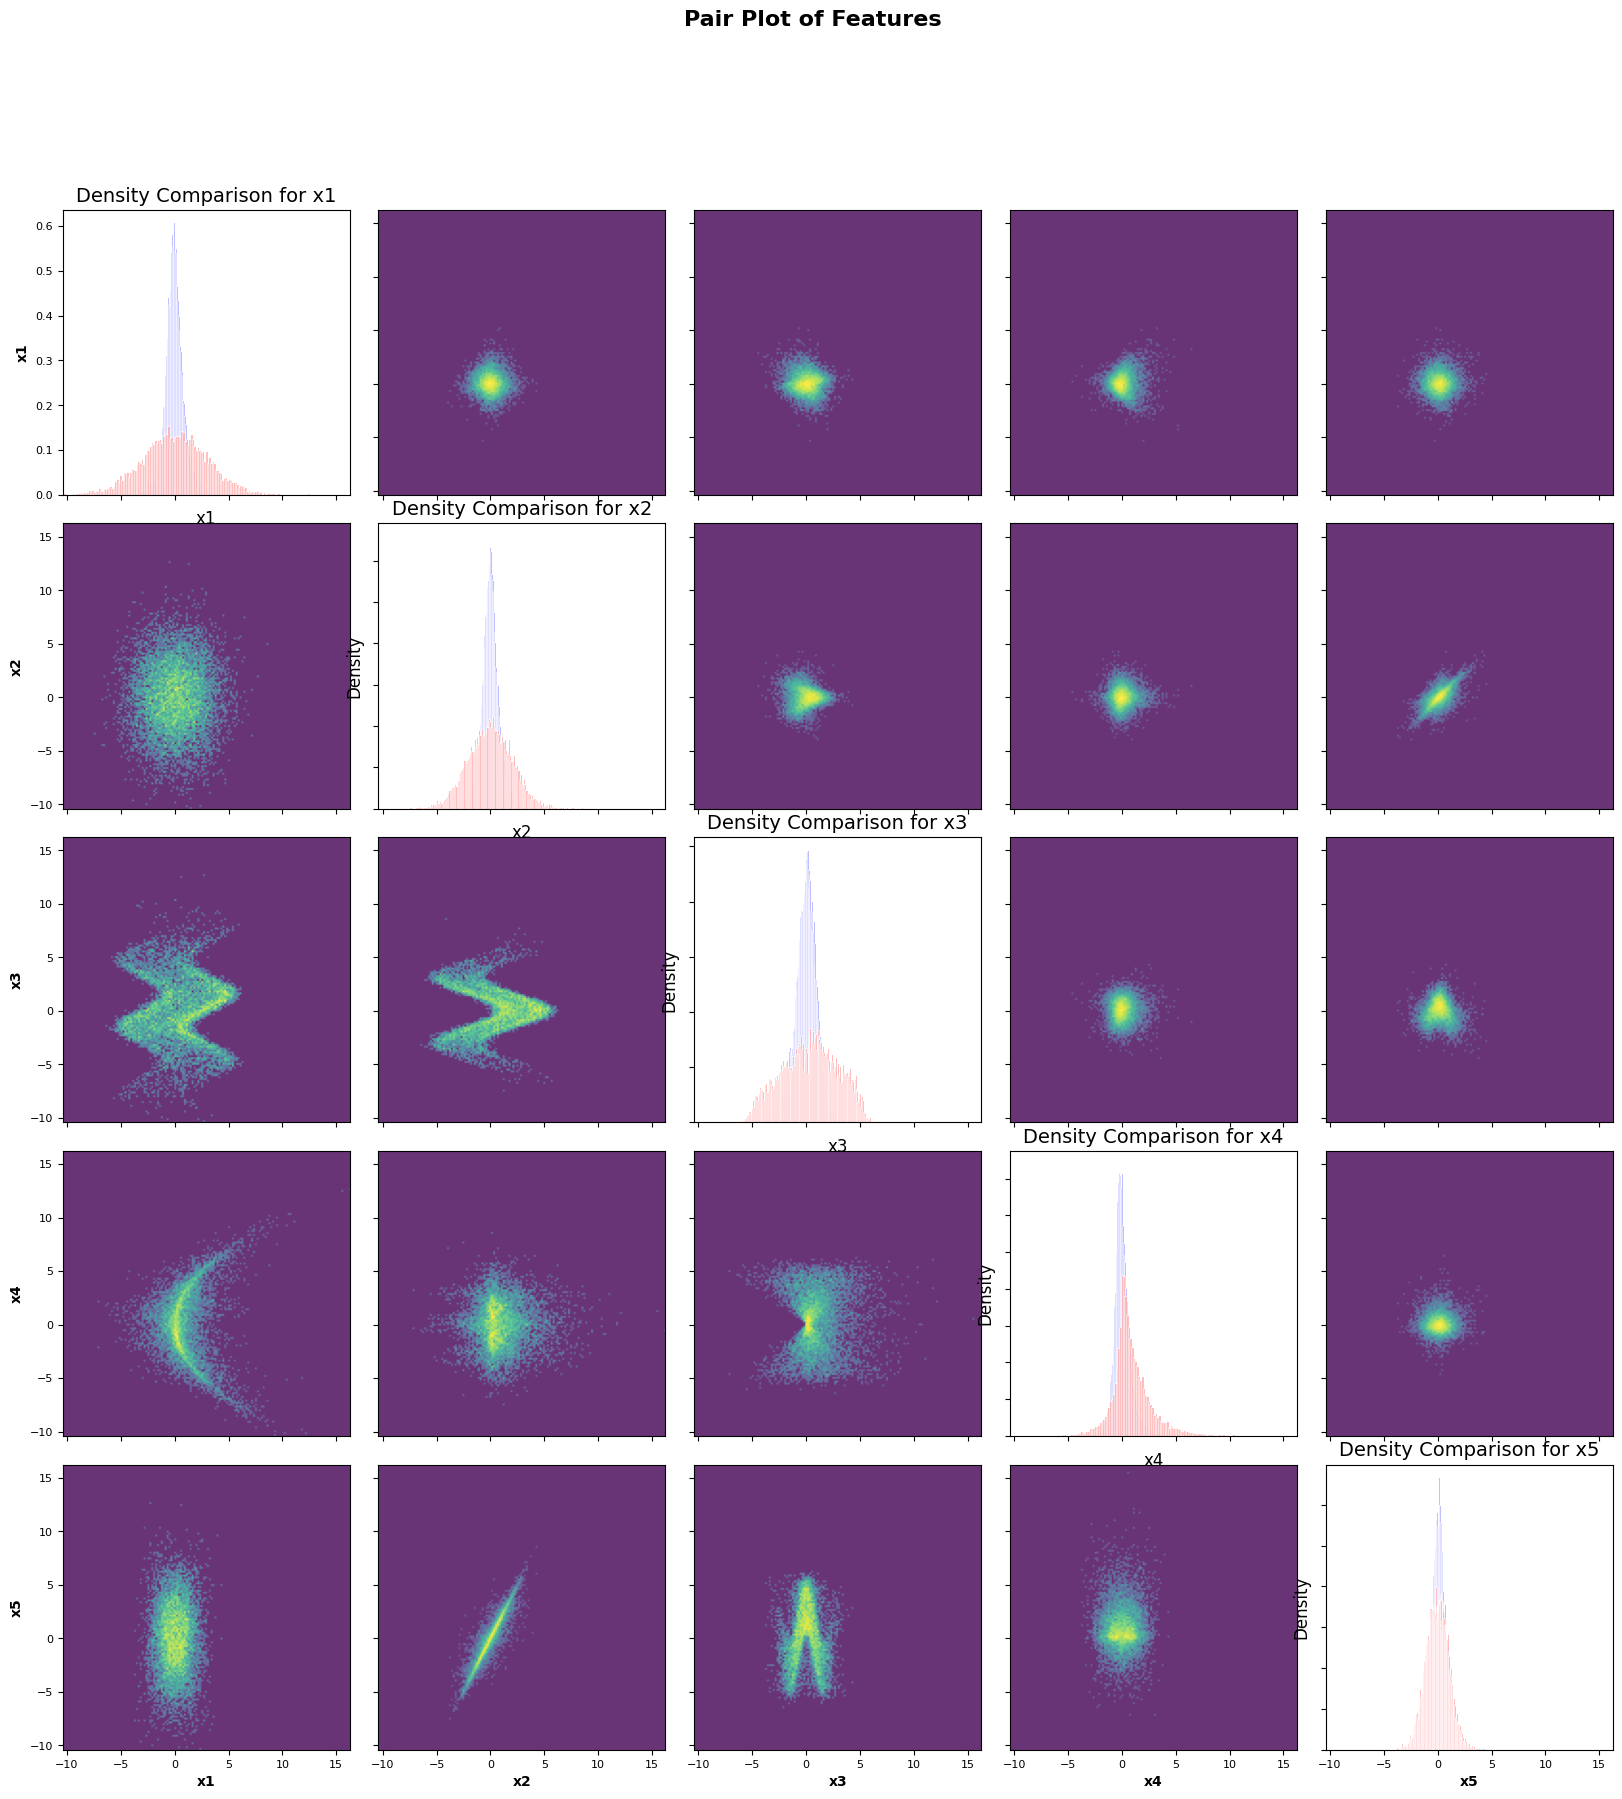

Comparison of Entire Datasets:
KS Statistic (averaged across dimensions) = 0.25224, p-value = 3.831014590402612e-70
Jensen-Shannon Divergence (averaged across dimensions) = 0.26657573019168
Mann-Whitney U Statistic (averaged across dimensions) = 45703996.5, p-value = 0.10885946053501201
High-Dimensional Pearson Correlation (averaged across dimensions) = 0.010467521258490995
High-Dimensional Wasserstein Distance = 3.2002657526454725


/srv/environments/alexanderm20/venvs/job_9503/lib/python3.12/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


In [10]:


test = torch.zeros(1, 1, dtype=torch.float32)  # Dummy observations
posterior.set_default_x(test)  # Set the default context for unconditioned sampling

# Sample 1000 points without condition from the posterior
num_samples_to_generate = 10000
samples = posterior.sample((num_samples_to_generate,))

# Step 5: Compare sampled points to input data distributions
samples_np = samples.numpy()


print(f"Generated samples shape: {samples_np.shape}")
print(f"Mean of samples: {samples_np.mean(axis=0)}")
print(f"Standard deviation of samples: {samples_np.std(axis=0)}")



plot_pairplot_comp_kde2(samples,data_new,labels)
compute_all_metrics(samples,data_new)

# 6) Testing Constraints

In [ ]:
Here I am testing how adding some constraints (prior knowledge) about functions/variables can improve the result of the results

For the example here, I provide the function for x1 and x2.
This is then added to the loss function of the diffusion model and guides it to respect this constraints. All of the Constraints are normalized and scaling factor can be adjusted (how much loss they generate)



(10000, 5)
[[ 4.46  -0.811 -0.5    2.206 -0.369]
 [ 1.706  3.103 -0.34  -0.341  1.549]
 [-2.098 -0.379  0.067 -1.139 -0.28 ]
 [-1.243 -0.779  0.992 -0.303 -0.37 ]
 [-2.306  0.789  0.128  0.004  0.357]
 [ 3.557 -2.23  -3.366  1.033 -1.191]
 [-0.703 -1.268  1.748  0.72  -0.807]
 [ 3.566  0.108  1.99   1.829 -0.047]
 [-0.555 -2.308 -3.823  0.796 -0.888]
 [-2.002 -1.684  1.605  1.348 -0.721]]


/srv/home/localusers/alexanderm20/P2/simformer-main/example/alex/Visualize.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96], pad=0.5)


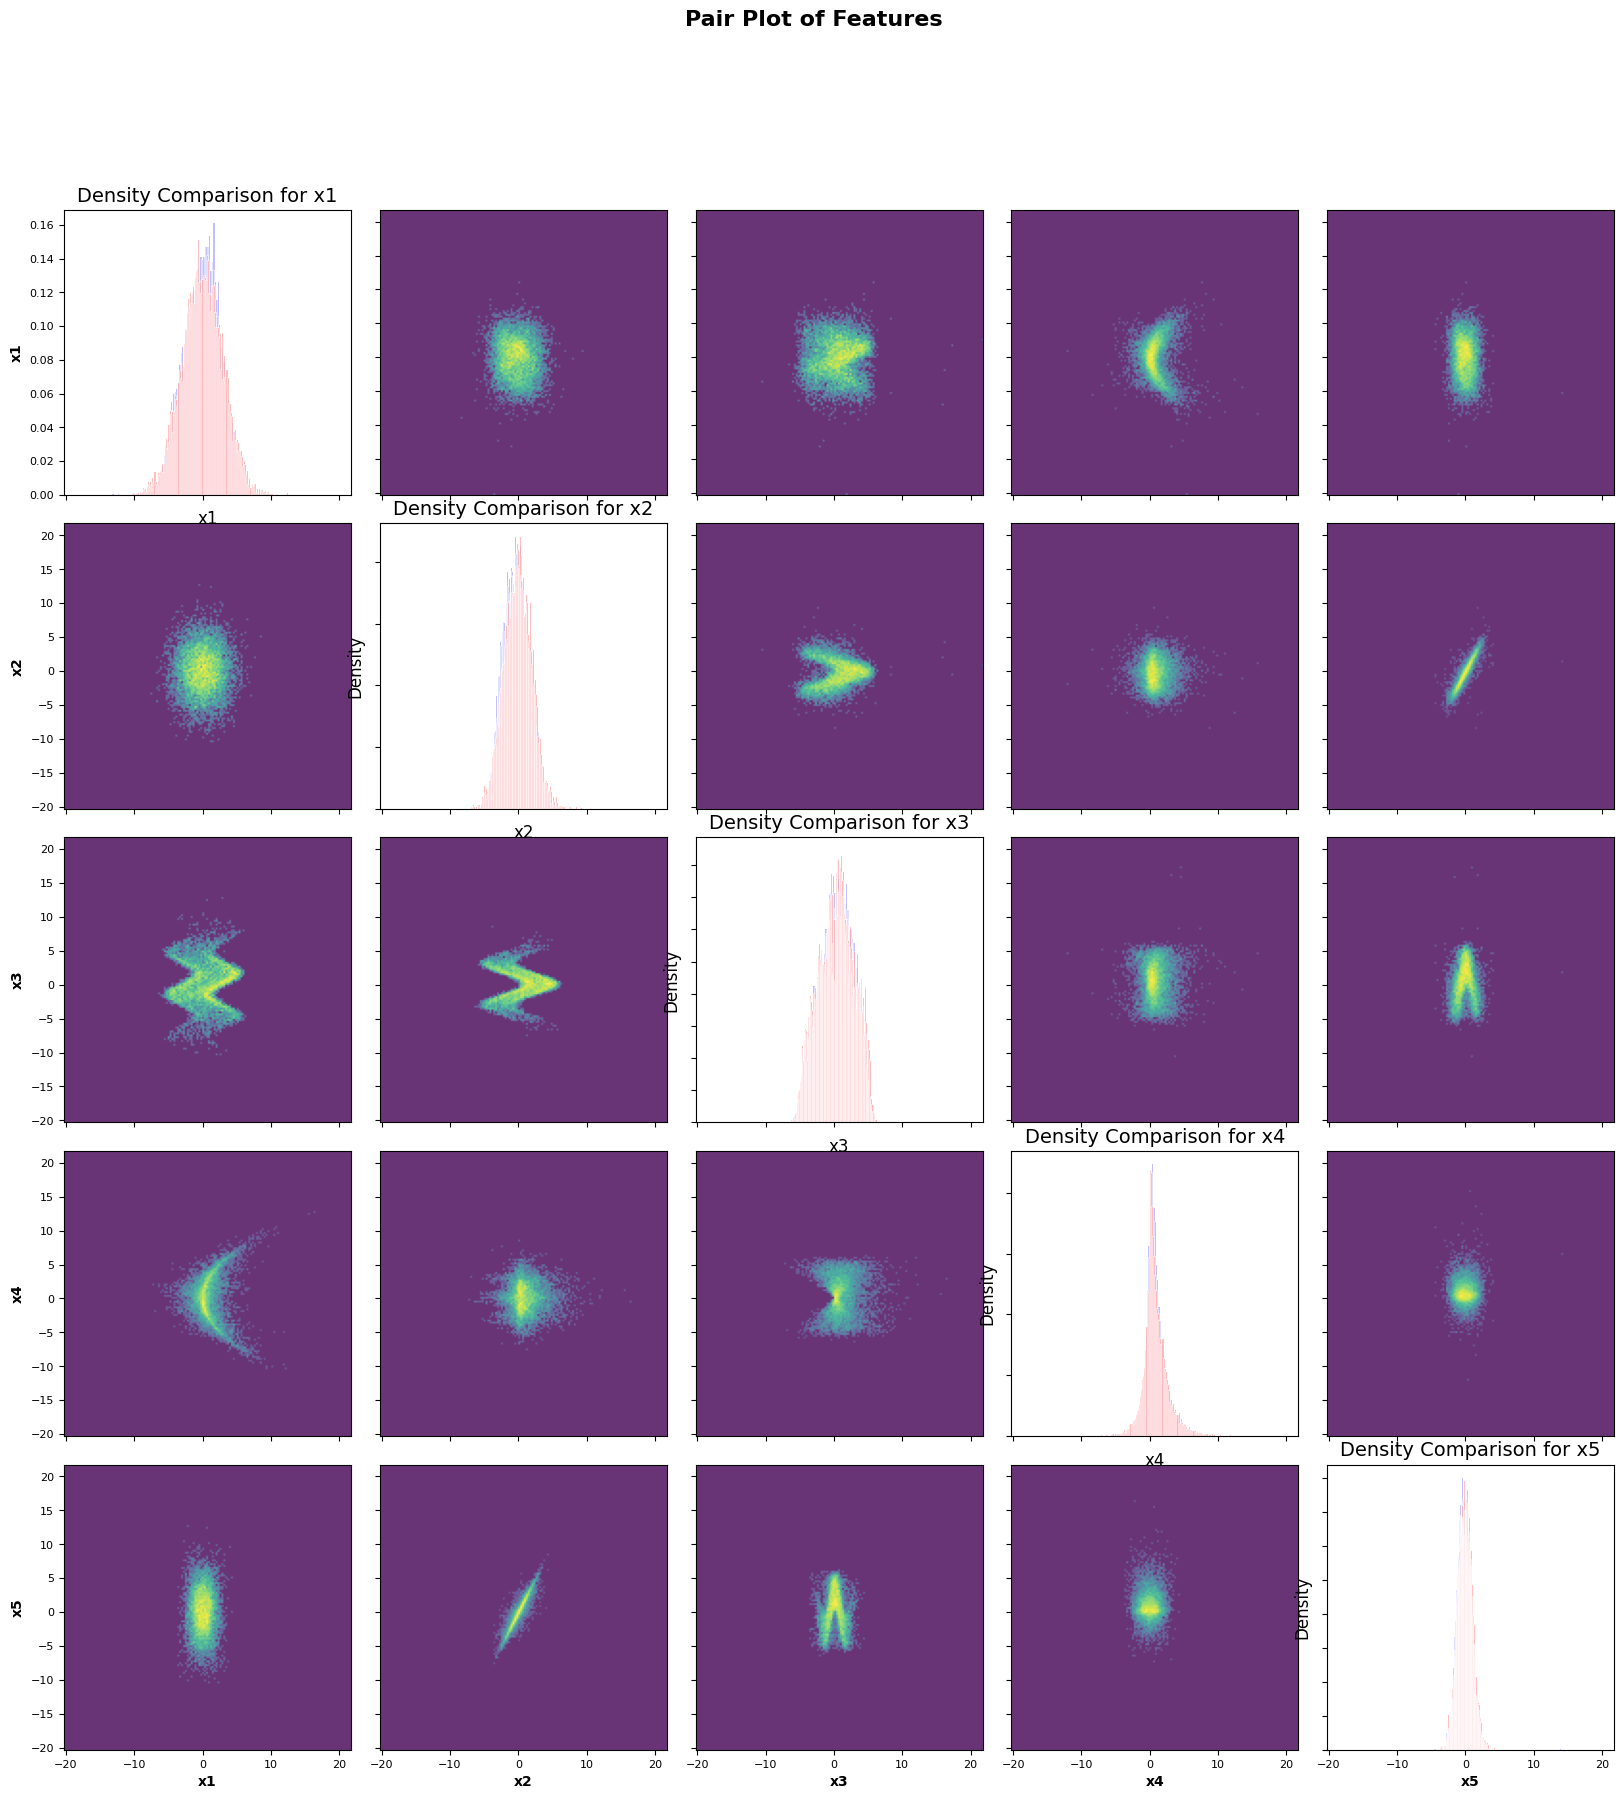

(Array(738390.8, dtype=float32), Array(658253.94, dtype=float32))
Old,New


In [11]:
import jax.numpy as jnp
import jax

class Constraint:
    def __init__(self, scale_factor=1000.0):
        self.scale_factor = scale_factor
    
    def evaluate(self, x):
        raise NotImplementedError
        
    def get_penalty(self, t, x):
        violation = self.evaluate(x)
        # Scale penalty based on time and violation magnitude
        scale = jnp.exp(-t**2 * 10) * self.scale_factor
        return scale * violation**2
class NormalizedConstraint(Constraint):
    def __init__(self, scale_factor=1000.0):
        super().__init__(scale_factor)
        self.means = means
        self.stds = stds
    
    def normalize(self, x):
        return (x - self.means) / self.stds
    
    def denormalize(self, x):
        return x * self.stds + self.means

class NormalizedX1Constraint(NormalizedConstraint):
    def __init__(self, key2, n, scale_factor=1000.0):
        super().__init__(scale_factor)
        self.key2 = key2
        self.n = n
    
    def evaluate(self, x):
        x_denorm = self.denormalize(x)
        theta1, theta2, x1 = x_denorm[:, 0], x_denorm[:, 1], x_denorm[:, 2]
        expected_x1 = 2 * jnp.sin(theta1) + 3 * jnp.cos(theta2) + jrandom.normal(self.key2, (self.n, 1)) * 0.5
        return jnp.abs(x1 - expected_x1)*self.scale_factor

class NormalizedX2Constraint(NormalizedConstraint):
    def __init__(self, key3, n, scale_factor=1000.0):
        super().__init__(scale_factor)
        self.key3 = key3
        self.n = n
    
    def evaluate(self, x):
        x_denorm = self.denormalize(x)
        theta1, x1, x2 = x_denorm[:, 0], x_denorm[:, 2], x_denorm[:, 3]
        expected_x2 = 0.1 * theta1**2 + 0.5 * jnp.abs(x1) * jrandom.normal(self.key3, (self.n, 1))
        return jnp.abs(x2 - expected_x2)*self.scale_factor



class EqualityConstraint(Constraint):
    def __init__(self, indices, coefficients, target_value=0.0, scale_factor=1000.0, penalty_factor=1.0):
        super().__init__(scale_factor)
        self.indices = indices
        self.coefficients = coefficients
        self.target_value = target_value
        self.penalty_factor = penalty_factor  # Add a custom factor to increase penalty
    
    def evaluate(self, x):
        x = x.reshape(x.shape[0], -1)
        result = sum(coef * x[:, idx] for idx, coef in zip(self.indices, self.coefficients))
        return jnp.abs(result - self.target_value)
    
    def get_penalty(self, t, x):
        violation = self.evaluate(x)
        scale = jnp.exp(-t**2 * 10) * self.scale_factor
        # Apply custom penalty factor to the computed penalty
        return scale * violation**2 * self.penalty_factor  # Increase penalty based on the factor

class InequalityConstraint(Constraint):
    def __init__(self, indices, coefficients, bound, direction='less', scale_factor=1000.0, penalty_factor=1.0):
        super().__init__(scale_factor)
        self.indices = indices
        self.coefficients = coefficients
        self.bound = bound
        self.direction = direction
        self.penalty_factor = penalty_factor  # Add a custom factor to increase penalty
    
    def evaluate(self, x):
        x = x.reshape(x.shape[0], -1)
        result = sum(coef * x[:, idx] for idx, coef in zip(self.indices, self.coefficients))
        if self.direction == 'less':
            return jnp.maximum(0, result - self.bound)
        else:
            return jnp.maximum(0, self.bound - result)
    
    def get_penalty(self, t, x):
        violation = self.evaluate(x)
        scale = jnp.exp(-t**2 * 10) * self.scale_factor
        # Apply custom penalty factor to the computed penalty
        return scale * violation**2 * self.penalty_factor  # Increase penalty based on the factor


class ConstraintManager:
    def __init__(self):
        self.constraints = []
    
    def add_constraint(self, constraint):
        self.constraints.append(constraint)
    
    def compute_total_penalty(self, t, x,score):
        total_penalty = 0.0
        tweedies_x0_estimator = (x + sde.marginal_stddev(t, jnp.array([1.]))**2 * score)/sde.marginal_mean(t, jnp.array([1.])) # Predict x0
        for constraint in self.constraints:
            grad = jax.grad(lambda *args: constraint.get_penalty(t,x).sum(), argnums=1)
            total_penalty += grad(t,tweedies_x0_estimator).reshape(-1, len(node_ids), 1) * condition_mask.reshape(-1, len(node_ids), 1)
        return total_penalty
    def compute_total_penalty_score(self, t, x):
        total_penalty = 0.0
        for constraint in self.constraints:
            total_penalty += constraint.get_penalty(t,x).sum()
        return total_penalty

# Modified scoring function
def check_variable_score(params, t, x, node_ids, condition_mask, edge_mask, constraint_manager):
    condition_mask = condition_mask[:len(node_ids)].reshape(-1, len(node_ids), 1)
    score = model_fn(params, t, x, node_ids=node_ids, 
                    condition_mask=jnp.zeros_like(condition_mask), 
                    edge_mask=edge_mask)
    
  
    penalty = constraint_manager.compute_total_penalty(t, x,score)
    return score + penalty


# Setup constraints
constraint_manager = ConstraintManager()

# These are the concret Constraints
class X1ConstraintEquation(Constraint):
    def __init__(self, key2, n, scale_factor=1000.0):
        super().__init__(scale_factor)
        self.key2 = key2
        self.n = n
    
    def evaluate(self, x):
        theta1, theta2, x1 = x[:, 0], x[:, 1], x[:, 2]
        expected_x1 = 2 * jnp.sin(theta1) + 3 * jnp.cos(theta2) + jrandom.normal(self.key2, (self.n, 1)) * 0.5
        return jnp.abs(x1 - expected_x1)

class X2ConstraintEquation(Constraint):
    def __init__(self, key3, n, scale_factor=1000.0):
        super().__init__(scale_factor)
        self.key3 = key3
        self.n = n
    
    def evaluate(self, x):
        theta1, x1, x2 = x[:, 0], x[:, 2], x[:, 3]
        expected_x2 = 0.1 * theta1**2 + 0.5 * jnp.abs(x1) * jrandom.normal(self.key3, (self.n, 1))
        return jnp.abs(x2 - expected_x2)

# Add constraints to manager
key2, key3 = jrandom.split(jrandom.PRNGKey(0), 2)
n = 10000  # adjust based on your sample size

constraint_manager.add_constraint(NormalizedX1Constraint(key2, n, scale_factor=10.0))
constraint_manager.add_constraint(NormalizedX2Constraint(key3, n, scale_factor=10.0))


# Create scoring function with constraints
score_fn2 = partial(check_variable_score, constraint_manager=constraint_manager)

# Sample with constraints
samples = sample_fn(
    key=jrandom.PRNGKey(70),
    shape=(10000,),
    score_fn=score_fn2,
    time_steps=500,
    node_ids=node_ids,
    condition_mask=condition_mask
)

samples = denormalize_data(samples, means, stds)
samples_new = samples[:,-1,:]
print(samples_new.shape)
print(samples_new[:10])
plot_pairplot_comp_kde2(samples_new,data_new,labels)


def evaluate_sampling_quality(generated_samples, reference_samples, constraint_manager):
    """
    Evaluate the quality of generated samples against reference samples by computing penalties.
    
    :param generated_samples: Samples generated with constraints applied
    :param reference_samples: Reference samples (without constraints or from another method)
    :param constraint_manager: The manager to compute penalties
    :return: A tuple of total penalties for the generated and reference samples
    """
    # Let's compute the total penalties for both the generated and reference samples
    total_penalty_generated = 0.0
    total_penalty_reference = 0.0
    t = 1
        
    total_penalty_generated += constraint_manager.compute_total_penalty_score(t, generated_samples).sum()/1000
    total_penalty_reference += constraint_manager.compute_total_penalty_score(t, reference_samples).sum()/1000

    return total_penalty_generated, total_penalty_reference
# left value is old loss value, right value is new loss value with the constraints
print(evaluate_sampling_quality(samples_ref, samples_new, constraint_manager))
print("Old,New")

Old value is on the left and new value on the right, this shows the loss function therefore a smaller value is better

In [12]:
# 1. Calculate bounds in normalized space
def get_normalized_bounds(data_clean, means, stds, target_var_idx=0, target_bounds=(1.0, 2.0)):
    """
    Calculate normalized bounds for constraints
    
    Args:
        data_clean: Clean dataset
        means: Normalization means
        stds: Normalization stds  
        target_var_idx: Index of variable to constrain
        target_bounds: Original space bounds (min, max)
    """
    # Convert original bounds to normalized space
    norm_min = (target_bounds[0] - means[target_var_idx]) / stds[target_var_idx]
    norm_max = (target_bounds[1] - means[target_var_idx]) / stds[target_var_idx]
    
    return (norm_min, norm_max)

# 2. Update constraint function
def check_variable_conditions(t, x, bounds):
    """
    params: model parameters
    t: time parameter 
    x: normalized data array (batch_size, num_nodes, 1)
    bounds: tuple of (normalized_min, normalized_max)
    """
    def s(t):
        t = jnp.atleast_1d(t)
        # Steeper scale function for stronger penalties
        return jnp.exp(-t**2 * 10) * 1000  # Increased multiplier for stricter bounds
    
    scale = s(t)
    norm_min, norm_max = bounds
    
    # Score calculation in normalized space with stronger penalties
    x = x.reshape(x.shape[0], -1) 
    penalty_min = scale * jax.nn.sigmoid(scale * (x - norm_min)) ** 2  # Squared to amplify penalty
    penalty_max = -scale * jax.nn.sigmoid(-scale * (x - norm_max)) ** 2  # Squared to amplify penalty
    score = penalty_min + penalty_max
    
    return score.reshape(x.shape[0], -1, 1)

check_variable_grad = jax.grad(lambda *args: check_variable_conditions(*args).sum(), argnums=1)

def check_variable_score(params, t, x, node_ids, condition_mask, edge_mask, bounds):
    condition_mask = condition_mask[:len(node_ids)].reshape(-1,len(node_ids), 1)
    score = model_fn(params,t, x, node_ids=node_ids, condition_mask=jnp.zeros_like(condition_mask), edge_mask=edge_mask)
    tweedies_x0_estimator = (x + sde.marginal_stddev(t, jnp.array([1.]))**2 * score)/sde.marginal_mean(t, jnp.array([1.])) # Predict x0
    interval_score_est = check_variable_grad(t,tweedies_x0_estimator,bounds).reshape(-1, len(node_ids), 1) * condition_mask.reshape(-1, len(node_ids), 1)
    return score + interval_score_est
# 3. Usage example 
# Calculate normalized bounds
target_bounds = (7.0, 8.0)  # Original space bounds
target_var_idx = 3  # First variable
norm_bounds = get_normalized_bounds(data_clean, means, stds, target_var_idx, target_bounds)

# Create scoring function
score_fn2 = partial(check_variable_score, bounds=norm_bounds)

# Sample with normalized constraints
samples = sample_fn(
    key=jrandom.PRNGKey(0),
    shape=(10000,),
    score_fn=score_fn2,
    time_steps=2000,
    node_ids=node_ids,
    condition_mask=condition_mask
)

# Denormalize for visualization
samples_denorm = denormalize_data(samples, means, stds)

def count_samples_within_bounds(samples, bounds):
    """
    Count the number of samples that satisfy the given normalized bounds.

    Args:
        samples (np.ndarray or jax.numpy.ndarray): Generated samples in normalized space (batch_size, num_nodes, 1)
        bounds (tuple): Normalized bounds (normalized_min, normalized_max)
    
    Returns:
        int: Count of samples within bounds
    """
    norm_min, norm_max = bounds
    
    # Flatten the samples to apply constraints across all nodes and samples
    flattened_samples = samples.reshape(-1)
    
    # Count samples within the normalized bounds
    count = ((flattened_samples >= norm_min) & (flattened_samples <= norm_max)).sum()
    
    return int(count)

# Example usage:
# Assuming `samples` is the output from the sampling function in normalized space
count = count_samples_within_bounds(samples, norm_bounds)

print(f"Number of samples within bounds with constraints: {count}")

samples = sample_fn(jrandom.PRNGKey(1), (10000,), node_ids, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)))
samples = denormalize_data(samples, means, stds)
samples_new2 = samples[:,-1,:]

count = count_samples_within_bounds(samples, norm_bounds)

print(f"Number of samples within bounds without constraints: {count}")


Number of samples within bounds with: 752912
Number of samples within bounds without: 606858


/srv/home/localusers/alexanderm20/P2/simformer-main/example/alex/Visualize.py:269: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96], pad=0.5)


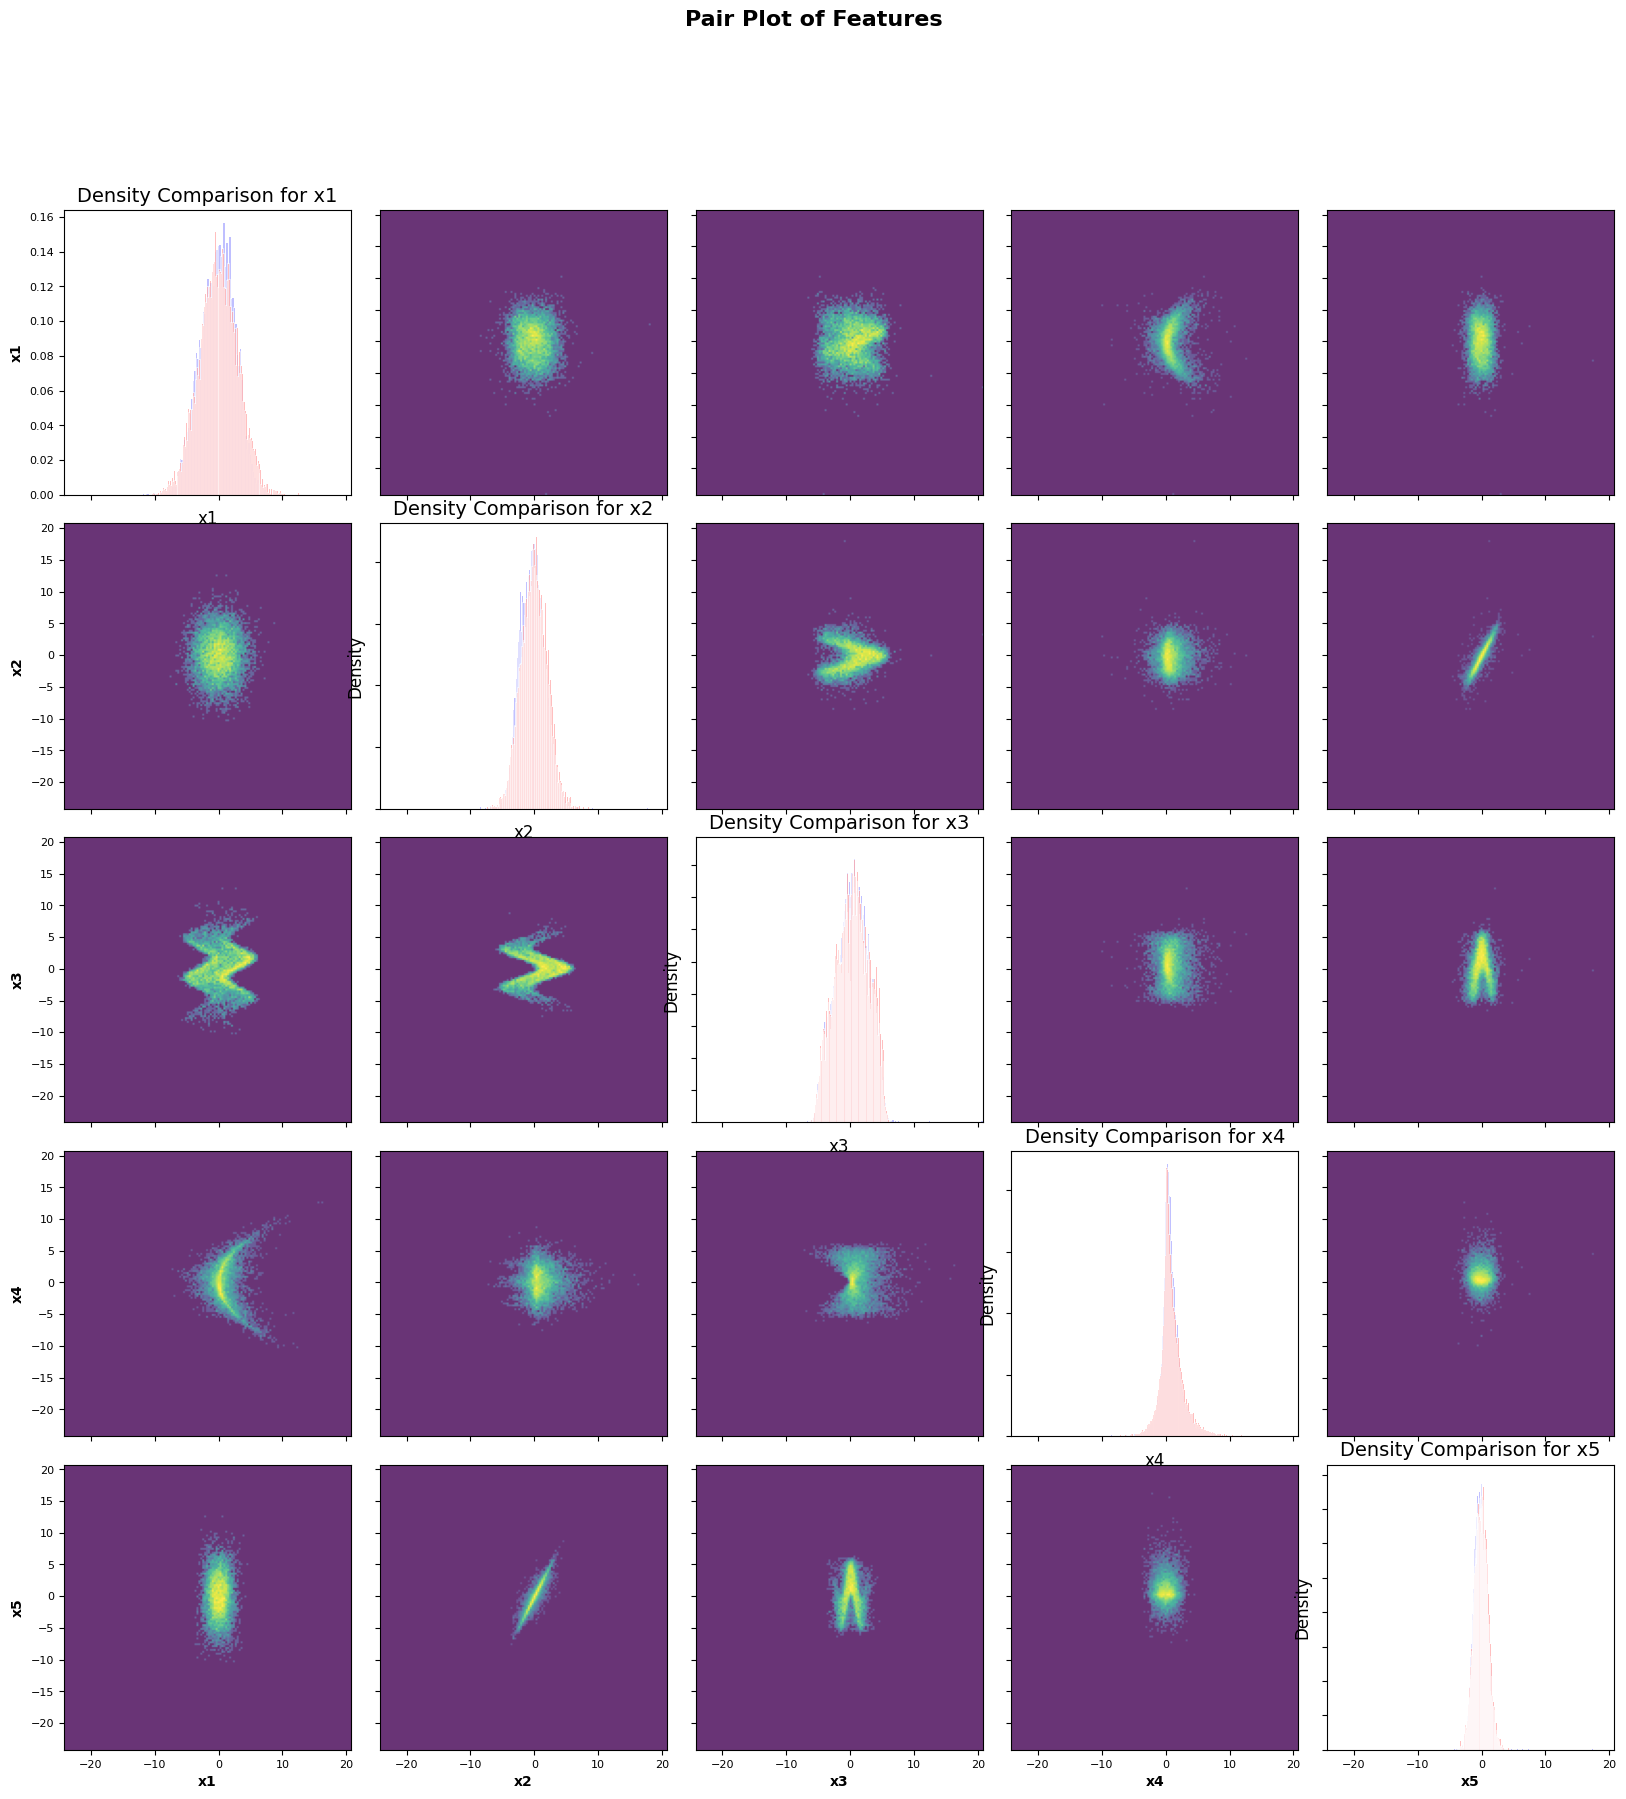

In [22]:
samples = denormalize_data(samples, means, stds)

samples_new = samples[:,-1,:]
#Hint bottom is the version with constraints, upper one the real data 
plot_pairplot_comp_kde2(samples_new2,data_new,labels)